#**_________Automatic Ticket Assignment________**

In [ ]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Summary of problem statement, data and findings**

### **Summary of problem statement**


1) IT  system depends on Incident Management process for effective Business operations without any impact.

2) Incident Management process --> assignment of incidents to appropriate IT groups.Incidents are created by various stakeholders (Business Users, IT Users and Monitoring Tools) within IT Service Management Tool and are assigned to Service Desk teams (L1 / L2 teams). 

3) L1 / L2 teams --> review the incidents for right ticket categorization, priorities and then carry out initial diagnosis to see if they can resolve. 

4) L3 teams --> incase L1 / L2 is unable to resolve, they will then escalate / assign the tickets to Functional teams from Applications and Infrastructure (L3 teams). 

**Challenges in this Process:**

1) Manual process (time consuming & human efforts)

(Minimum ~25-30% of incidents needs to be reviewed for SOPs before ticket assignment).
5 min is being spent for SOP review for each incident.

2) incidents getting assigned to wrong functional groups. 

Additional effort needed  to re-assign to right functional groups

3) satisfaction deterioration / poor customer service.

incidents are in queue and not addressed on time


**Solution :**

Guided by powerful AI & ML techniques that can classify incidents to right functional groups can help organizations to reduce the resolving time of the issue and can focus on more productive tasks.

**data and findings**

In [ ]:
#Import and install necessary libraries

In [ ]:
!pip install xgboost

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

## NLTK Downloads
nltk.download('stopwords')
stop = set(stopwords.words('english')) 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.cm as cm
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib.cm import get_cmap

import itertools
import os

import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [ ]:
#Read the dataset
df = pd.read_excel (r'/content/drive/MyDrive/AIML_PGP_Projects/Projects/Capstone/input_data.xlsx')
df.head()

Short description  ... Assignment group
0                    login issue  ...            GRP_0
1                        outlook  ...            GRP_0
2             cant log in to vpn  ...            GRP_0
3  unable to access hr_tool page  ...            GRP_0
4                   skype error   ...            GRP_0

[5 rows x 4 columns]

In [ ]:
#shape, Columns & info of dataset
print(df.shape)
print(df.columns)
print(df.info())

(8500, 4)
Index(['Short description', 'Description', 'Caller', 'Assignment group'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB
None


### Observation:

- There are 4 columns and all are string columns
- There are totally 8500 rows and there seems to be mising values in Short description and Description columns, which needs to be looked into and handled
- Caller columns mainly contains the details of the user who raised the incident.
- Assignment group is our predictor / target column with multiple classes. 
- This is a Multiclass Classification problem 

## **2. Summary of the Approach to EDA and Pre-processing**

**EDA**

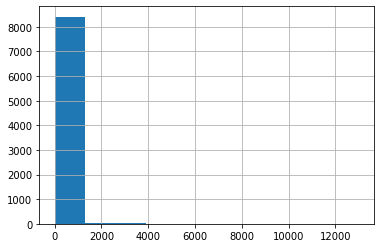

In [ ]:
# Plot string len of desc and short des
df['Description'].str.len().hist()

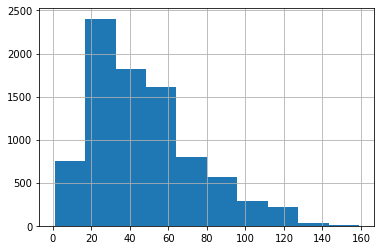

In [ ]:
df['Short description'].str.len().hist()

In [ ]:
df['Assignment group'].value_counts()[:20] #top 20 groups

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      184
GRP_13     145
GRP_10     140
GRP_5      129
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_17      81
Name: Assignment group, dtype: int64

In [ ]:
df['Assignment group'].nunique() #Number of unique groups

74

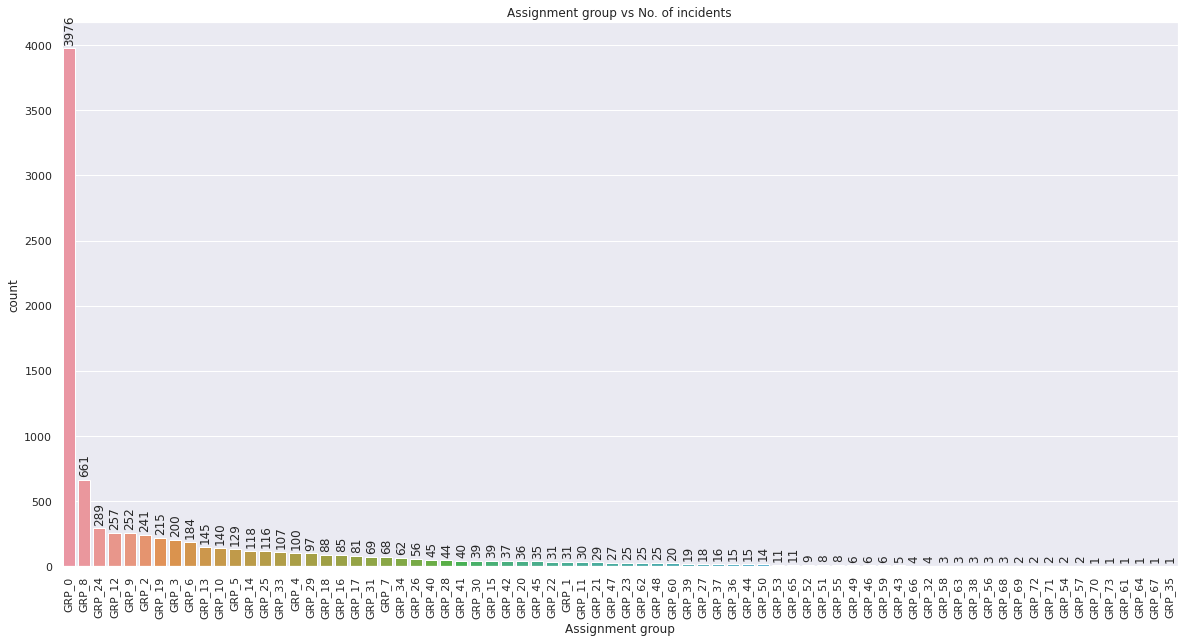

In [ ]:
#plotting Assignment group vs No. of incidents
plt.figure(figsize=(20,10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Assignment group", data= df, order = df['Assignment group'].value_counts().index)

for item in ax.get_xticklabels():
  item.set_rotation(90)

for p in ax.patches:
  #ax.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+5))
  ax.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+50),rotation=90)

plt.title('Assignment group vs No. of incidents')
plt.show()

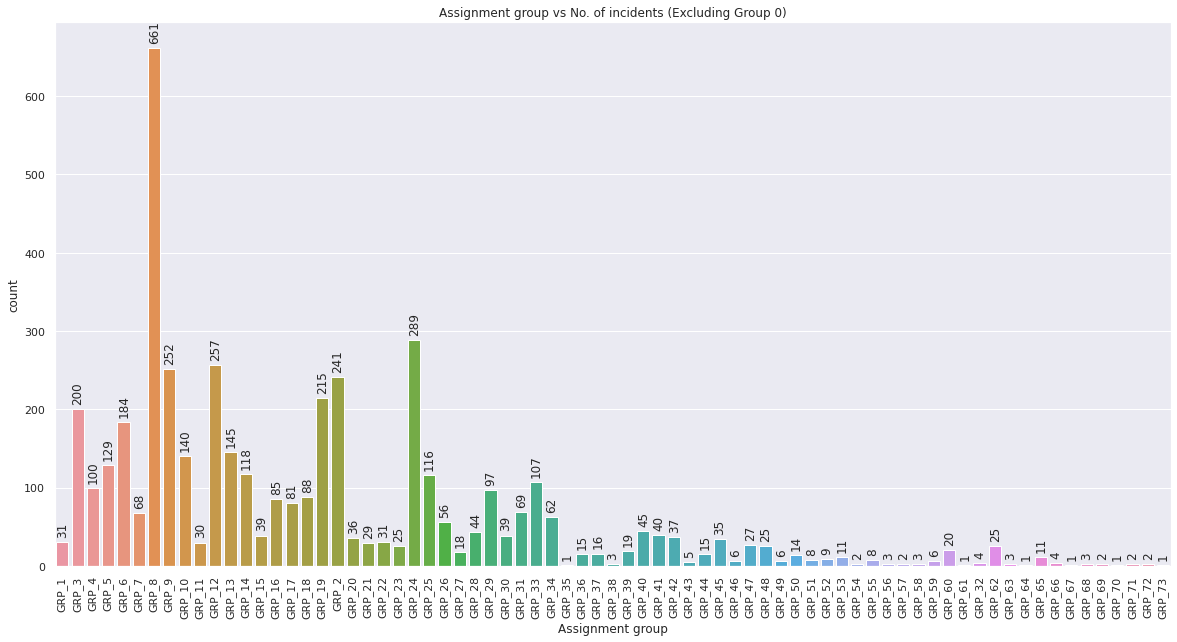

In [ ]:
## View the Distribution of only records that DONOT belong to GRP_0
plt.figure(figsize=(20,10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Assignment group", data=df[df['Assignment group'] != 'GRP_0'])
for item in ax.get_xticklabels():
  item.set_rotation(90)

for p in ax.patches:
  #ax.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+5))
  ax.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+10),rotation=90)

plt.title('Assignment group vs No. of incidents (Excluding Group 0)')
plt.show()

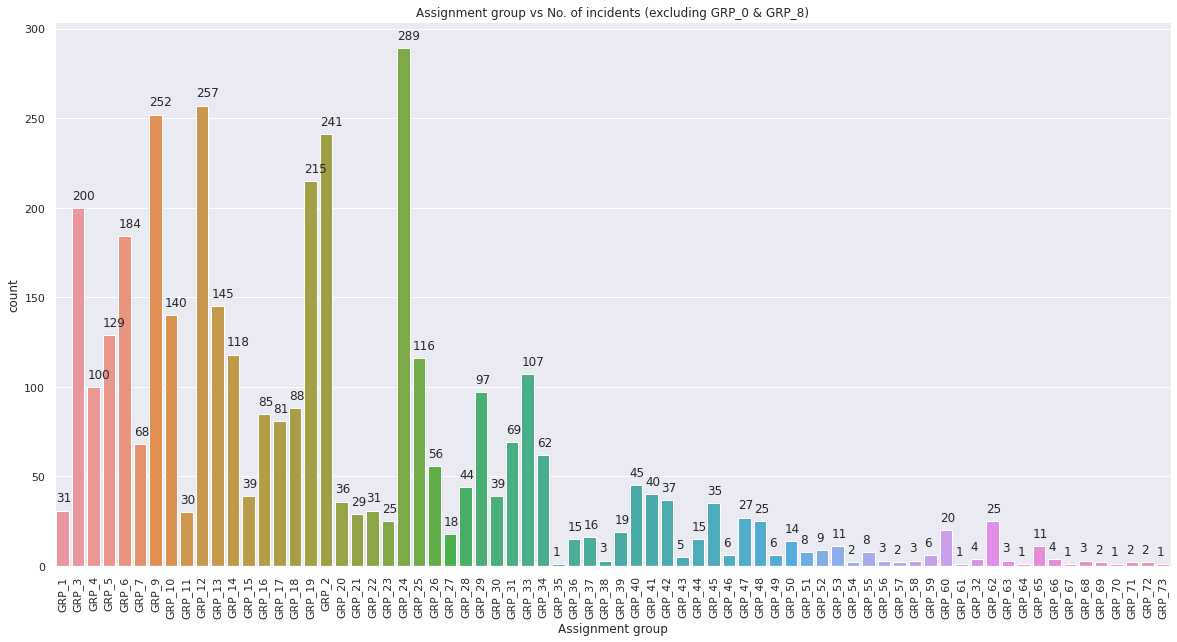

In [ ]:
## View the Distribution of only records that DONOT belong to GRP_0 & GRP_8
plt.figure(figsize=(20,10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Assignment group", data=df[((df['Assignment group'] != 'GRP_0')&(df['Assignment group'] != 'GRP_8'))])

for item in ax.get_xticklabels():
  item.set_rotation(90)

for p in ax.patches:
  ax.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+5))

plt.title('Assignment group vs No. of incidents (excluding GRP_0 & GRP_8)')
plt.show()

more number of tickets are from Grp_0(3976), grp_8(661), others have less then 300 to 1. 

this is an imbalanced dataset

In [ ]:
#to find the observations with null data
df[df.isnull().any(axis=1)]

Short description  ... Assignment group
2604                       NaN  ...           GRP_34
3383                       NaN  ...            GRP_0
3906                       NaN  ...            GRP_0
3910                       NaN  ...            GRP_0
3915                       NaN  ...            GRP_0
3921                       NaN  ...            GRP_0
3924                       NaN  ...            GRP_0
4341                       NaN  ...            GRP_0
4395  i am locked out of skype  ...            GRP_0

[9 rows x 4 columns]

In [ ]:
# number of missing values 
pd.DataFrame( df.isnull().sum(), columns= ['Number of missing values'])

Number of missing values
Short description                         8
Description                               1
Caller                                    0
Assignment group                          0

In [ ]:
#Fininding Duplicate records 
df_copy = df[['Short description', 'Description', 'Caller','Assignment group']].copy()
duplicateRowsDF = df_copy[df_copy.duplicated()]
duplicateRowsDF

Short description  ... Assignment group
51                           call for ecwtrjnq jpecxuty  ...            GRP_0
229                          call for ecwtrjnq jpecxuty  ...            GRP_0
493                     ticket update on inplant_872730  ...            GRP_0
512                                    blank call //gso  ...            GRP_0
667   job bkbackup_tool_powder_prod_full failed in j...  ...            GRP_8
...                                                 ...  ...              ...
7836             probleme mit erpgui \tmqfjard qzhgdoua  ...           GRP_24
8051               issue on pricing in distributor_tool  ...           GRP_21
8093  reset passwords for prgthyuulla ramdntythanjes...  ...           GRP_17
8347                           blank call // loud noise  ...            GRP_0
8405                           unable to launch outlook  ...            GRP_0

[83 rows x 4 columns]

In [ ]:
# Remove Duplicates
incidents_upd = df.drop_duplicates(['Short description', 'Description', 'Caller', 'Assignment group'],keep='first')

In [ ]:
print(df.shape)
print(incidents_upd.shape)

(8500, 4)
(8417, 4)


In [ ]:
## Group by Categories
df_grp = incidents_upd.groupby(['Assignment group']).size().reset_index(name='Group_counts')
df_grp

Assignment group  Group_counts
0             GRP_0          3934
1             GRP_1            31
2            GRP_10           140
3            GRP_11            30
4            GRP_12           257
..              ...           ...
69           GRP_71             2
70           GRP_72             2
71           GRP_73             1
72            GRP_8           645
73            GRP_9           252

[74 rows x 2 columns]

In [ ]:
df_grp.describe() #Understanding distribution of tickets count across groups

Group_counts
count     74.000000
mean     113.743243
std      460.731077
min        1.000000
25%        5.250000
50%       26.000000
75%       81.000000
max     3934.000000

In [ ]:
#Visualize the Dsitribution of Records across Groups

In [ ]:
sns.set_style("darkgrid")

## distibution based on Percentage
df_grp["count_perc"] = round((df_grp["Group_counts"]/df.shape[0])*100,2)
df_grp.sort_values(["count_perc"], axis=0, 
                 ascending=False, inplace=True) 

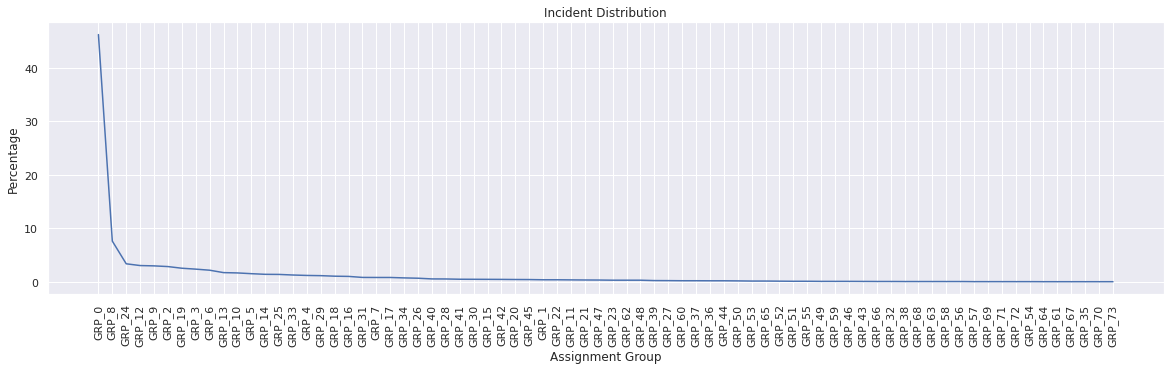

In [ ]:
## View the % Distribution of all Records
plt.subplots(figsize = (20,5))
 
plt.plot(df_grp["Assignment group"], df_grp["count_perc"]) 
plt.xlabel('Assignment Group') 
plt.ylabel('Percentage') 
plt.xticks(rotation=90)
plt.title('Incident Distribution') 
  
 
plt.show() 

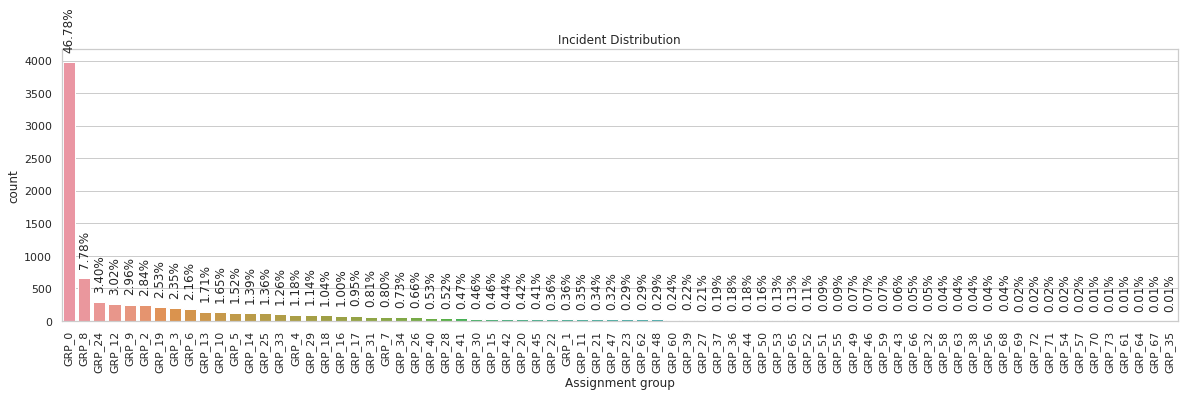

In [ ]:
# Plot to visualize the percentage data distribution across different groups
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
ax = sns.countplot(x="Assignment group", data=df, order=df["Assignment group"].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
  ax.annotate(str(format(p.get_height()/len(df.index)*100, '.2f')+"%"), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', rotation=90, xytext = (0, 10), textcoords = 'offset points')

plt.title('Incident Distribution') 
plt.show() 

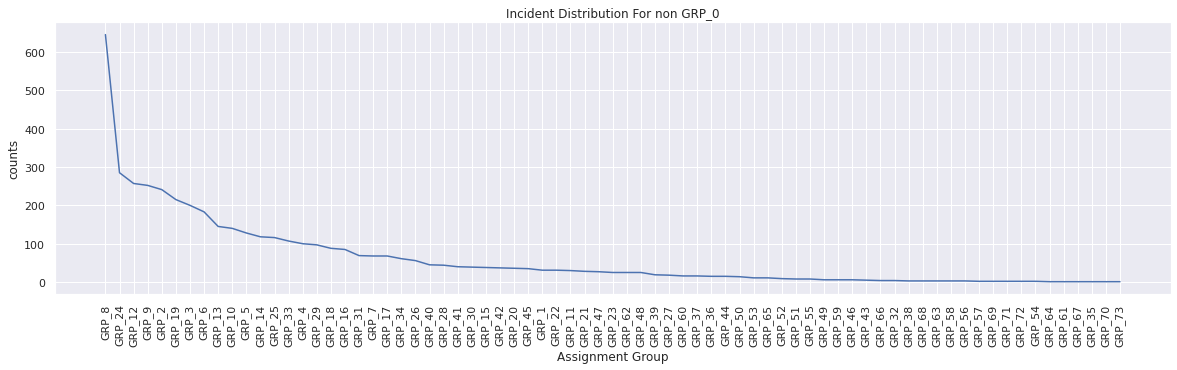

In [ ]:
## View the Distribution of only records that DONOT belong to GRP_0
df_test = df_grp[df_grp["Assignment group"] != 'GRP_0']
plt.subplots(figsize = (20,5))

plt.plot(df_test["Assignment group"], df_test["Group_counts"]) 
plt.xlabel('Assignment Group') 
plt.ylabel('counts') 
plt.xticks(rotation=90)

plt.title('Incident Distribution For non GRP_0') 
plt.show() 

In [ ]:
#storing group count and % in a dataframe
df_inc = incidents_upd['Assignment group'].value_counts().reset_index()
df_inc['percentage'] = (df_inc['Assignment group']/df_inc['Assignment group'].sum())*100
df_inc.head()

index  Assignment group  percentage
0   GRP_0              3934   46.738743
1   GRP_8               645    7.663063
2  GRP_24               285    3.386005
3  GRP_12               257    3.053344
4   GRP_9               252    2.993941

#### Observation
-This is a imbalanced dataset, with majority of incidents are from Group 0 followed by Group 8 , 24 , 12 , 9 , 2 and so on

-There are few classes which just have less 10 incidents pers class and even classed with just 1 or 2 incidents, need to see if   we can club all less numbered ticket groups into one single group or drop those rows due to the lack of samples representing those classes. They might not be of much help as a predictor

In [ ]:
#Distribution of tickets counts in various bins
df_bins = pd.DataFrame(columns=['Description','Ticket Count'])
one_ticket = {'Description':'1 ticket','Ticket Count':len(df_inc[df_inc['Assignment group'] < 2])}
_2_5_ticket = {'Description':'2-5 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 1)& (df_inc['Assignment group'] < 6) ])}
_10_ticket = {'Description':' 6-10 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 5)& (df_inc['Assignment group'] < 11)])}
_10_20_ticket = {'Description':' 11-20 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 10)& (df_inc['Assignment group'] < 21)])}
_20_50_ticket = {'Description':' 21-50 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 20)& (df_inc['Assignment group'] < 51)])}
_51_100_ticket = {'Description':' 51-100 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 50)& (df_inc['Assignment group'] < 101)])}
_100_ticket = {'Description':' >100 ticket',
              'Ticket Count':len(df_inc[(df_inc['Assignment group'] > 100)])}
#append row to the dataframe
df_bins = df_bins.append([one_ticket,_2_5_ticket,_10_ticket,
                          _10_20_ticket,_20_50_ticket,_51_100_ticket,_100_ticket], ignore_index=True)

df_bins

Description Ticket Count
0        1 ticket            6
1      2-5 ticket           13
2     6-10 ticket            6
3    11-20 ticket            9
4    21-50 ticket           16
5   51-100 ticket            9
6     >100 ticket           15

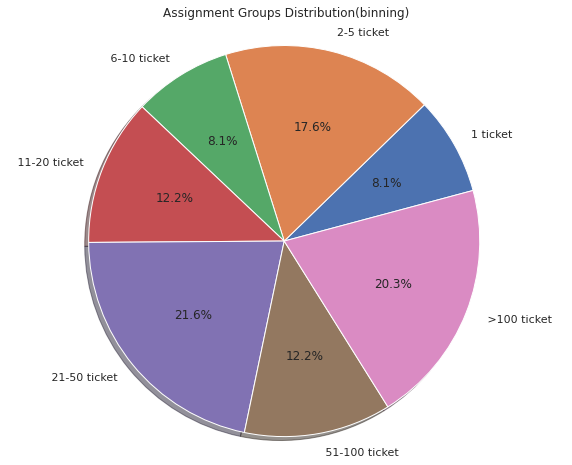

In [ ]:
plt.figure(figsize=(10, 8))
plt.pie(df_bins['Ticket Count'],labels=df_bins['Description'],autopct='%1.1f%%', startangle=15, shadow = True);
plt.title('Assignment Groups Distribution(binning)')
plt.axis('equal');

In [ ]:
incidents_upd['Assignment group'].value_counts()[:30]

GRP_0     3934
GRP_8      645
GRP_24     285
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      183
GRP_13     145
GRP_10     140
GRP_5      128
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_31      69
GRP_17      68
GRP_7       68
GRP_34      62
GRP_26      56
GRP_40      45
GRP_28      44
GRP_41      40
GRP_30      39
GRP_15      38
GRP_42      37
Name: Assignment group, dtype: int64

In [ ]:
Groups = list(incidents_upd['Assignment group'].value_counts()[:16].index) #storing group names with tickets >= 100
print(len(Groups))

16


In [ ]:
## create a column to mark records with GRP_0 and non GRP_0=>GRP_X
incidents_upd['GRP_Temp'] = incidents_upd['Assignment group'].apply(lambda x: 'GRP_Clubbed' if x not in Groups else x)
incidents_upd['GRP_Temp'].value_counts()

GRP_0          3934
GRP_Clubbed    1351
GRP_8           645
GRP_24          285
GRP_12          257
GRP_9           252
GRP_2           241
GRP_19          215
GRP_3           200
GRP_6           183
GRP_13          145
GRP_10          140
GRP_5           128
GRP_14          118
GRP_25          116
GRP_33          107
GRP_4           100
Name: GRP_Temp, dtype: int64

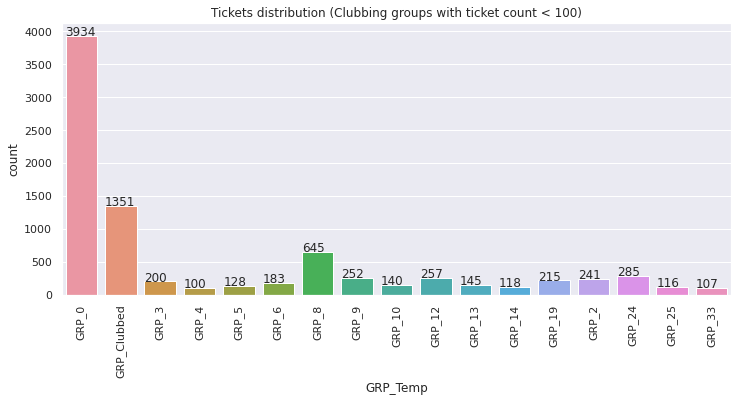

In [ ]:
sns.set(rc={'figure.figsize':(12, 5)})
ax1 = sns.countplot(x="GRP_Temp", data=incidents_upd)
for item in ax1.get_xticklabels():
  item.set_rotation(90)

for p in ax1.patches:
  ax1.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+5))

plt.title('Tickets distribution (Clubbing groups with ticket count < 100)')
plt.show()

In [ ]:
#To check how many number of classes we end up for modelling if the class threshold(no. of tickets per group) > [200, 100, 50, 40, 30, 20, 10]

In [ ]:
x = df['Assignment group'].value_counts(ascending = False)
dx = x.to_frame()
dx = dx.reset_index()
dx.columns = ['grp','count']
#dx.head(2)

class_threshold = [200, 100, 50, 40, 30, 20, 10]
num_of_classes = []

In [ ]:
def num_classes (n) :
  i = 0
  i = len(dx[dx['count'] > n])
  return (i + 1) 
  # +1 for the 'other' class

In [ ]:
for l in class_threshold:
  num_of_classes.append(num_classes(l))

#print (num_of_classes)
df_classes = pd.DataFrame(list(zip(class_threshold, num_of_classes)),
               columns =['class_threshold', 'num_of_classes'])

df_classes.head(10)

class_threshold  num_of_classes
0              200               8
1              100              16
2               50              25
3               40              27
4               30              35
5               20              41
6               10              50

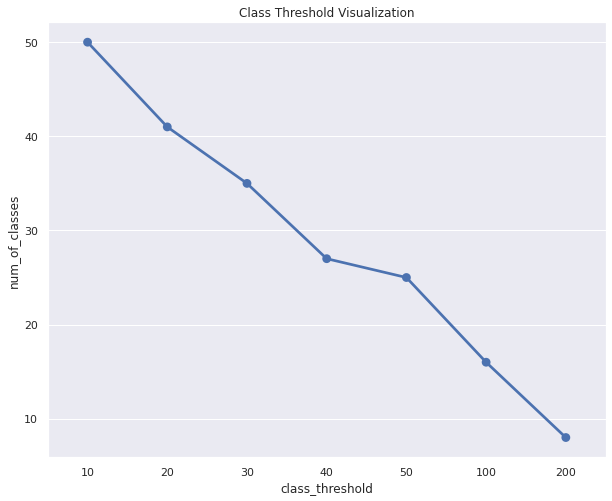

In [ ]:
sns.set(rc={'figure.figsize':(10, 8)})
sns.pointplot(x = "class_threshold", y = "num_of_classes", data = df_classes)

plt.title('Class Threshold Visualization')
plt.show()

In [ ]:
df[df['Assignment group'] == 'GRP_30'] #Data has some special characters . Example data in Grp 30

Short description  ... Assignment group
276   outlookæ”¶åˆ°ç®±ä¸­folderå˜ä¸ºæ¯å¤©ä¸€ä¸ªfol...  ...           GRP_30
1178                              ç”µè¯æœºæ²¡æœ‰å£°éŸ³  ...           GRP_30
1271             fe10 å¤å°å‡ºæ¥çº¸å¼ æ–‡å­—ä¸æ¸…æ™°  ...           GRP_30
1452            è€ƒå‹¤ç³»ç»Ÿè¿›ä¸åŽ»è¯·å¤„ç†è°¢è°¢ï¼  ...           GRP_30
1805                                  wifi ä¸èƒ½åœ¨çº¿  ...           GRP_30
1954                        ç¬”è®°æœ¬é‡æ–°è£…ä¸‹ç³»ç»Ÿ  ...           GRP_30
1955                     æœ‰ä¸€ä¸ªé“¾æŽ¥æ–‡ä»¶æ‰“ä¸å¼€  ...           GRP_30
2736                             vpnå®‰è£…-è½¬è´ºæ­£å¹³  ...           GRP_30
2980  hp2çƒ­åŽ‹ç‚‰æ•°æ®ä¼ è¾“å¡ï¼Œæ•°æ®æ›´æ–°ä¸å...  ...           GRP_30
3120               ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚  ...           GRP_30
3137                                 é‚®ç®±æ— æ³•å¯åŠ¨  ...           GRP_30
3300   outlookæ— æ³•ç™»é™† ,ä¸€ç›´æ˜¾ç¤ºæ­£åœ¨å¯åŠ¨ã€‚  ...           GRP_30
3307  erpç³»ç»Ÿç™»å½•åŽï¼Œé‡‡è´­é¡µé¢æ— æ³•æ˜¾ç¤º"...  ...           GRP_30
3713               e-time ç³»ç»Ÿjavaæ›´æ–°-è½¬è´ºæ­£å¹³  ...           GRP_30
3903  ç”µè„‘æ— æ³•è¿žæŽ¥å…¬å…±ç›˜ï¼Œè¯·å¸®æˆ‘è½¬ç»™å...  ...           GRP_30
4028                                 ä¼ çœŸæœºä¸æ¸…æ¥š  ...           GRP_30
4090  çƒ­åŽ‹ç‚‰4å·plcæŽ§åˆ¶å™¨é€šè®¯æ¨¡å—ç½‘ç»œåœ°...  ...           GRP_30
4098  ç”µè„‘æ„å¤–è¿›æ°´ï¼Œå¸®åŠ©å¤„ç†ï¼è¯·äº¤å°è...  ...           GRP_30
4599  outloot  è€æ˜¯æç¤ºè¾“å…¥å¯†ç ï¼Œæ›´æ”¹å¯†ç...  ...           GRP_30
5149                                       å¼€ä¸äº†æœº  ...           GRP_30
5303      æŠ¥ç¨Žç”µè„‘ä¸èƒ½è”ç½‘ï¼Œè®©è´ºæ­£å¹³ä¼‘ã€‚  ...           GRP_30
5731  ç”µè„‘è¿è¡Œé€Ÿåº¦è¶…çº§æ…¢ï¼Œæ‰“å¼€ä¸€ä¸ªerpæ...  ...           GRP_30
5847             repeat outbound connection for 135/tcp  ...           GRP_30
5890  iphoneä¸Šçš„skypeä¸èƒ½ç™»å½•ä¸èƒ½å‚åŠ ä¼šè®...  ...           GRP_30
5913                                 é‚®ç®±ç™»å½•ä¸äº†  ...           GRP_30
6106                                 ç”µè„‘ä¸èƒ½å¼€æœº  ...           GRP_30
6148  29866 vid22518 bare http get executable from i...  ...           GRP_30
7126                        ç”µè„‘å¡ä¸”è¿žä¸ä¸Šå†…ç½‘  ...           GRP_30
7302                               skypeä¼šè®®æ—¶ä¸åŽ»  ...           GRP_30
7307  å®žä¹ ç”Ÿç™»å½•office365ä¸‹è½½é‚®ä»¶é™„ä»¶æ—¶æ...  ...           GRP_30
7309               é¤åŽ…ç”µè§†æ— æ³•æ’­æ”¾è§†é¢‘æ–‡ä»¶  ...           GRP_30
7582              æ–‡ä»¶æ— æ³•é€šè¿‡æ‰“å°æœºfe08æ‰“å°  ...           GRP_30
7588                                    æ˜¾ç¤ºå™¨ä¸äº®  ...           GRP_30
7987  security incidents - (in33536629) : possible t...  ...           GRP_30
8266         erpæ— æ³•è¿›è¡Œé‡‡è´­ï¼ˆè½¬ç»™è´ºæ­£å¹³ï¼‰  ...           GRP_30
8270              å¯†ç æ›´æ”¹åŽï¼Œoutlookæ— æ³•ç™»é™†  ...           GRP_30
8457                    æ— æ³•ç™»é™†hr_toolè€ƒå‹¤ç³»ç»Ÿ  ...           GRP_30
8465                                   vpn è¿žæŽ¥ä¸ä¸Š  ...           GRP_30
8471                           ç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥  ...           GRP_30

[39 rows x 4 columns]

In [ ]:
df.columns

Index(['Short description', 'Description', 'Caller', 'Assignment group'], dtype='object')

In [ ]:
#Understanding 'Caller' column

In [ ]:
print(df.Caller.nunique())
print(df.shape)

2950
(8500, 4)


In [ ]:
df.Caller.value_counts() #caller vs no.of tickets

bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
                    ... 
qufjnslk bvtfrwnu      1
imzctxhr odmawbij      1
wyjsbzda yfeuhtib      1
wgmnjxft zeyhasdj      1
knpodsal pzdkcimf      1
Name: Caller, Length: 2950, dtype: int64

In [ ]:
df.Caller.value_counts()[:10] #top10 callers

bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
jloygrwh acvztedi     64
spxqmiry zpwgoqju     63
oldrctiu bxurpsyi     57
olckhmvx pcqobjnd     54
jyoqwxhz clhxsoqy     51
Name: Caller, dtype: int64

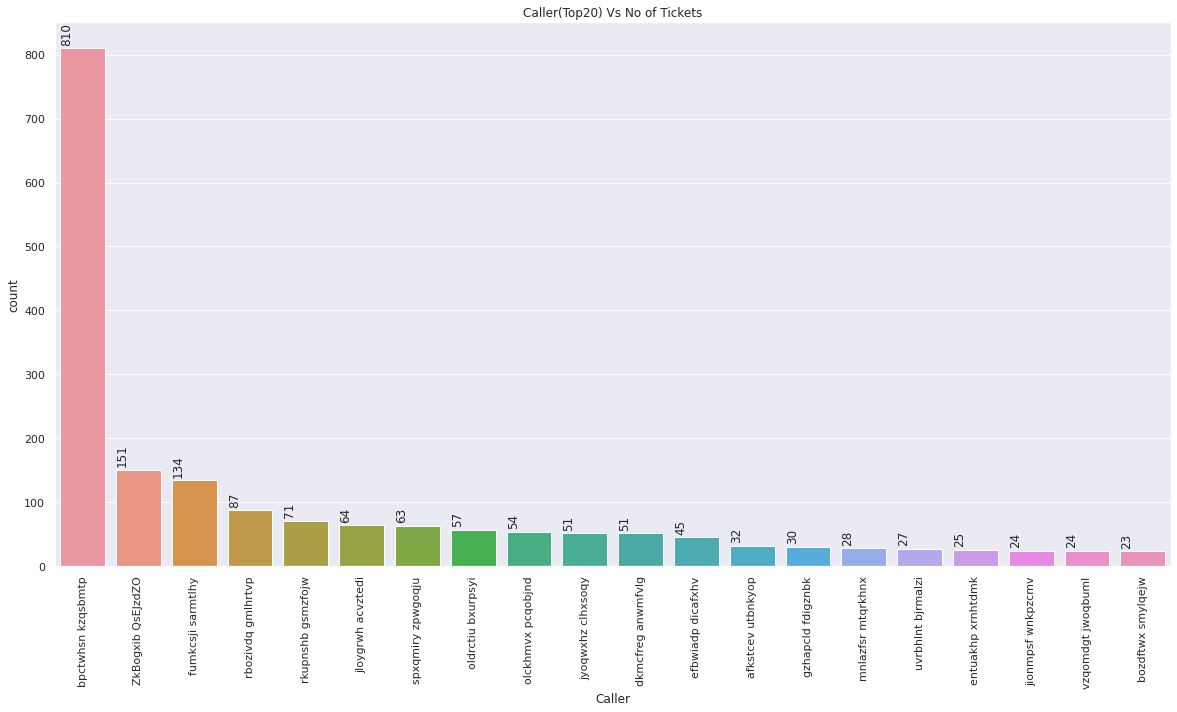

In [ ]:
plt.figure(figsize=(20,10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Caller", data= df, order = df['Caller'].value_counts()[:20].index)

for item in ax.get_xticklabels():
  item.set_rotation(90)

for p in ax.patches:
  #ax.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+5))
  ax.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+10),rotation=90)

plt.title('Caller(Top20) Vs No of Tickets')
plt.show()

In [ ]:
df[df.Caller == 'bpctwhsn kzqsbmtp']["Assignment group"].value_counts()

GRP_8     362
GRP_9     153
GRP_5      96
GRP_6      89
GRP_10     60
GRP_60     16
GRP_12      8
GRP_45      7
GRP_1       6
GRP_13      4
GRP_18      3
GRP_47      2
GRP_57      1
GRP_14      1
GRP_44      1
GRP_29      1
Name: Assignment group, dtype: int64

In [ ]:
df[df.Caller == 'ZkBogxib QsEJzdZO']["Assignment group"].value_counts()

GRP_8     54
GRP_6     35
GRP_9     31
GRP_5     16
GRP_47     8
GRP_29     2
GRP_10     2
GRP_14     2
GRP_1      1
Name: Assignment group, dtype: int64

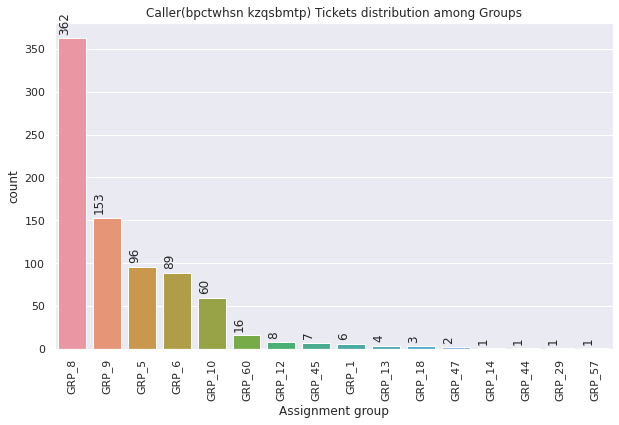

In [ ]:
#Caller(bpctwhsn kzqsbmtp) Tickets distribution among Groups
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Assignment group", data= df[df.Caller == 'bpctwhsn kzqsbmtp'], order = df[df.Caller == 'bpctwhsn kzqsbmtp']['Assignment group'].value_counts()[:20].index)

for item in ax.get_xticklabels():
  item.set_rotation(90)

for p in ax.patches:
  #ax.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+5))
  ax.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+8),rotation=90)

plt.title('Caller(bpctwhsn kzqsbmtp) Tickets distribution among Groups')
plt.show()

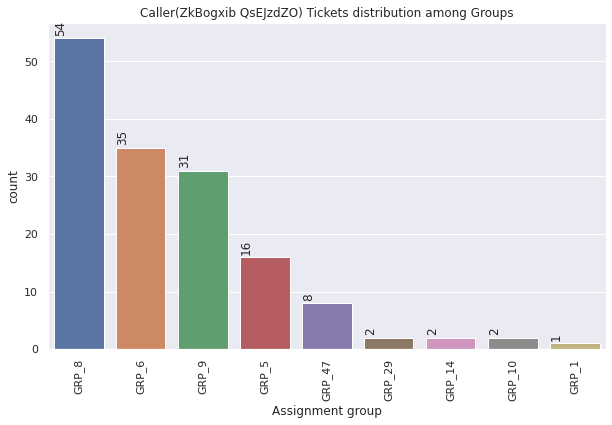

In [ ]:
#Caller(ZkBogxib QsEJzdZO) Tickets distribution among Groups
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Assignment group", data= df[df.Caller == 'ZkBogxib QsEJzdZO'], order = df[df.Caller == 'ZkBogxib QsEJzdZO']['Assignment group'].value_counts()[:20].index)

for item in ax.get_xticklabels():
  item.set_rotation(90)

for p in ax.patches:
  #ax.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+5))
  ax.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+1),rotation=90)

plt.title('Caller(ZkBogxib QsEJzdZO) Tickets distribution among Groups')
plt.show()

##### **Data Pre-Processing**

In [ ]:
## merging the Short Description and Description Columns
incidents_sum = pd.DataFrame({"Description": incidents_upd["Short description"] + " " + incidents_upd["Description"],
                              "Caller" : incidents_upd['Caller'],
                             "AssignmentGroup": incidents_upd["Assignment group"]}, 
                              columns=["Description","Caller","AssignmentGroup"])

In [ ]:
incidents_sum.head()

Description  ... AssignmentGroup
0  login issue -verified user details.(employee# ...  ...           GRP_0
1  outlook \r\n\r\nreceived from: hmjdrvpb.komuay...  ...           GRP_0
2  cant log in to vpn \r\n\r\nreceived from: eylq...  ...           GRP_0
3  unable to access hr_tool page unable to access...  ...           GRP_0
4                          skype error  skype error   ...           GRP_0

[5 rows x 3 columns]

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [ ]:
## NLTK Downloads
nltk.download('stopwords')
stop = set(stopwords.words('english')) 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [ ]:
#function for lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
#specifying the field "Description" datatype, (in this case, its string)
incidents_sum["Description"] = incidents_sum["Description"].astype(str) 

In [ ]:
t1 = time()
temp =[]
temp_sent = []
for sentence in incidents_sum["Description"]:
    sentence = sentence.lower() #converting to lowercase character
    #sentence = sentence.str.replace('\d+', '')
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
    sentence = re.sub(r'\S+@\S+', 'emailid', sentence) #substituting eamil ids with 'emailid'
    sentence = re.sub(r'\'', '', sentence, re.I|re.A)
    sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A) #Removing numbers
    #print ("Sentence1.5 = ",sentence)
    sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence) #Removing special characters
    #print ("Sentence2 = ",sentence)
    #sentence = sentence.lower()
    sentence = re.sub(r'com ', ' ', sentence, re.I|re.A) #removing com (which is a frequent word)
    sentence = re.sub(r'hello ', ' ', sentence, re.I|re.A)#removing hello (which is a frequent word)
    l_sentence = lemmatize_sentence(sentence)
    sentence = re.sub(r'receive ', ' ', sentence, re.I|re.A)#removing receive (which is a frequent word)
    sentence = re.sub(r'emailid ', ' ', sentence, re.I|re.A)##removing emailid (which is a frequent word)

    words = [word for word in l_sentence.split() if word not in stopwords.words('english')] #Remove stopwords
    words = list(set(words)) #Taking only unique words
    temp.append(words)
    cleaned_sent = " ".join(words) #Joining the words to form a sentence
    temp_sent.append(cleaned_sent)

print('Time to Preprocess the data: {} mins'.format(round((time() - t1) / 60, 2)))

Time to Preprocess the data: 0.75 mins


In [ ]:
#Storing preprocessed data
incidents_sum["Description_Preprocessed"] = temp
incidents_sum["Cleaned_sent"] = temp_sent

In [ ]:
incidents_sum.head(10)

Description  ...                                       Cleaned_sent
0  login issue -verified user details.(employee# ...  ...  issue employee password name resolve able user...
1  outlook \r\n\r\nreceived from: hmjdrvpb.komuay...  ...  calendar correct emailid receive advise team e...
2  cant log in to vpn \r\n\r\nreceived from: eylq...  ...               log emailid best receive cant vpn hi
3  unable to access hr_tool page unable to access...  ...                         page unable tool access hr
4                          skype error  skype error   ...                                        skype error
5  unable to log in to engineering tool and skype...  ...                  engineering log unable tool skype
6  event: critical:HostName_221.company.com the v...  ...  threshold value company perpsrpsad event sid o...
7  ticket_no1550391- employment status - new non-...  ...  employee status new employment non name user t...
8  unable to disable add ins on outlook unable to...  ...                         add disable outlook unable
9  ticket update on inplant_874773 ticket update ...  ...                              inplant update ticket

[10 rows x 5 columns]

In [ ]:
incidents_sum.to_excel("incidents_sum.xlsx",index=False)

In [ ]:
# We observed that lemmatization of the junk characters returned blank array and hence we use that condition
#to remove the rows with blank arrays in 'Description_Preprocessed' column
incidents_sum1 = incidents_sum[incidents_sum['Description_Preprocessed'].map(lambda d: len(d)) > 0]

In [ ]:
print(incidents_sum.shape)
print(incidents_sum1.shape)

(8417, 5)
(8381, 5)


In [ ]:
#Word Cloud Visualization - We will try to visualize word clouds for GRP_0, Non GRP_0 
#and some of the Groups apart from GRP_0 that had higher number of Incidents

In [ ]:
## GRP_0 Visualization:
## create a column to mark records with GRP_0 and non GRP_0=>GRP_X
incidents_sum1['GRP_MOD'] = incidents_sum1['AssignmentGroup'].apply(lambda x: 'GRP_X' if x != 'GRP_0' else x)

In [ ]:
incidents_sum1.columns

Index(['Description', 'Caller', 'AssignmentGroup', 'Description_Preprocessed',
       'Cleaned_sent', 'GRP_MOD'],
      dtype='object')

#### Let use word cloud to visualize the type of words used in Description

One very handy visualization tool for a data scientist when it comes to any sort of natural language processing is plotting "Word Cloud". A word cloud (as the name suggests) is an image that is made up of a mixture of distinct words which may make up a text or book and where the size of each word is proportional to its word frequency in that text (number of times the word appears). Here our words can simply be taken from the column "Description_Preprocessed"

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.cm as cm

In [ ]:
stopwords = set(STOPWORDS)

## function to create Word Cloud
def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

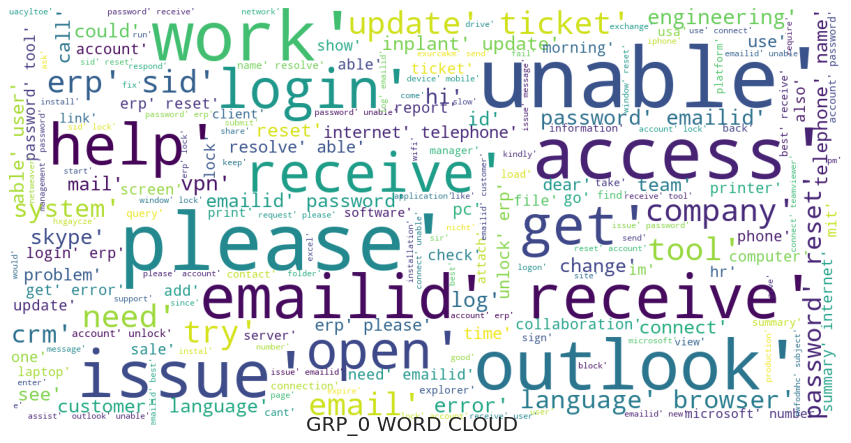

In [ ]:
## view word cloud for GRP_0
text_Str = incidents_sum1['Description_Preprocessed'][incidents_sum1['GRP_MOD'].isin(["GRP_0"])].tolist()
show_wordcloud(text_Str, "GRP_0 WORD CLOUD")

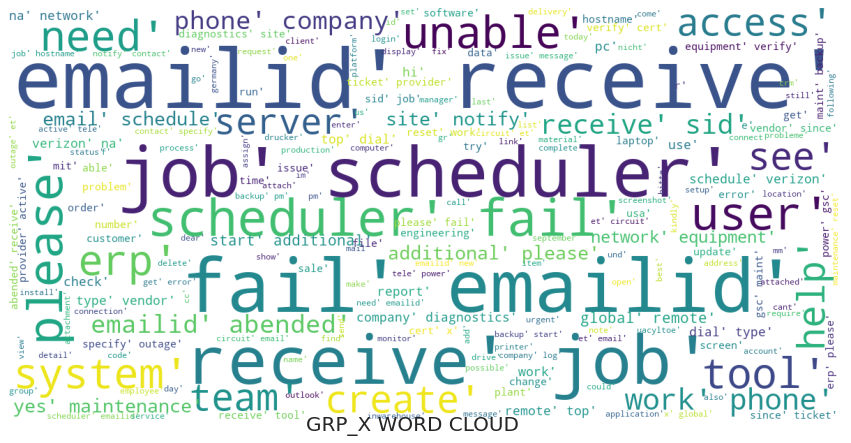

In [ ]:
## GRP_X Visualization:
text_Str = incidents_sum1['Description_Preprocessed'][incidents_sum1['GRP_MOD'].isin(["GRP_X"])].tolist()
show_wordcloud(text_Str, "GRP_X WORD CLOUD")

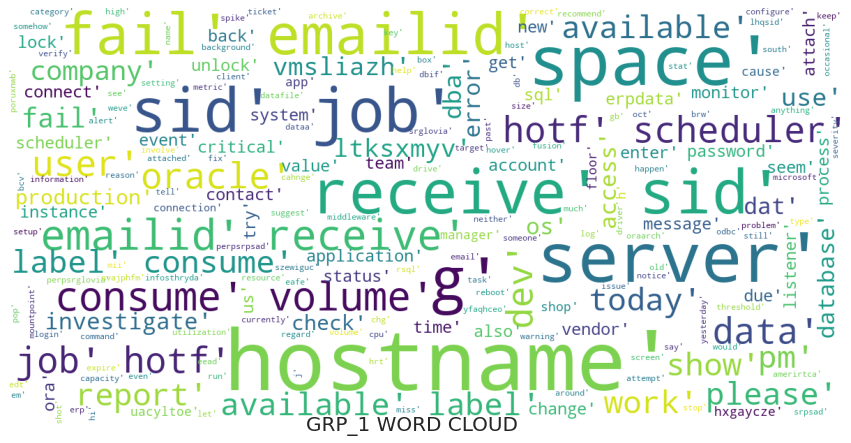

In [ ]:
text_Str1 = incidents_sum['Description_Preprocessed'][incidents_sum['AssignmentGroup'].isin(["GRP_1"])].tolist()
show_wordcloud(text_Str1,"GRP_1 WORD CLOUD" )

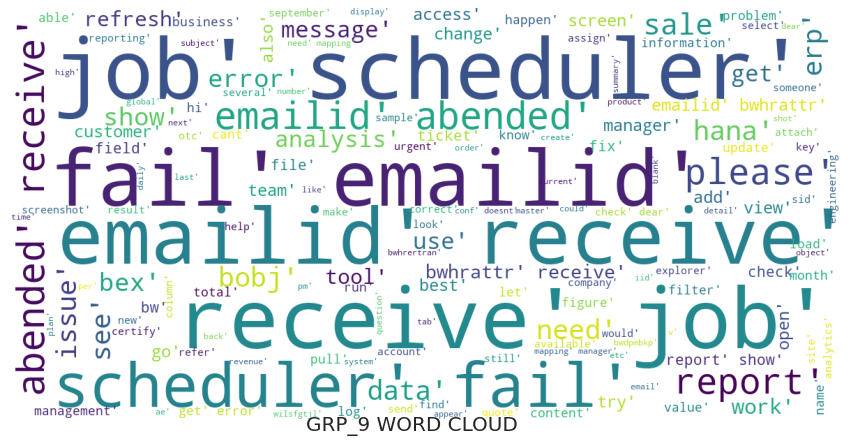

In [ ]:
text_Str1 = incidents_sum['Description_Preprocessed'][incidents_sum['AssignmentGroup'].isin(["GRP_9"])].tolist()
show_wordcloud(text_Str1,"GRP_9 WORD CLOUD" )

In [ ]:
#Word Clouds for Groups that have higher incidents other than GRP_0

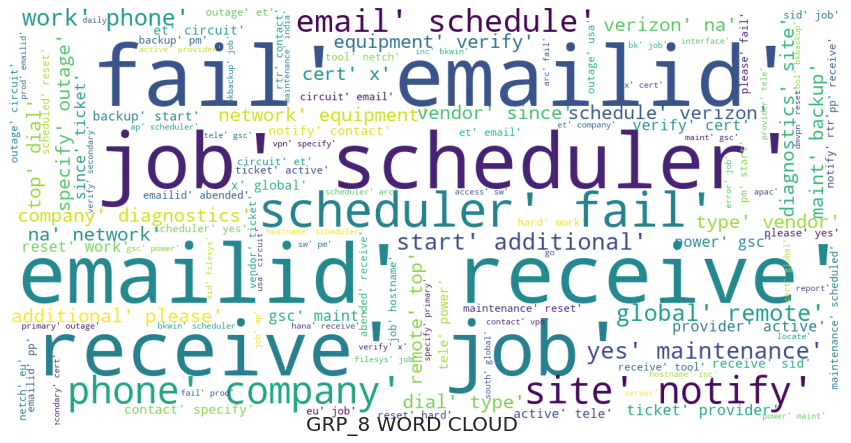

In [ ]:
text_Str1 = incidents_sum['Description_Preprocessed'][incidents_sum['AssignmentGroup'].isin(["GRP_8"])].tolist()
show_wordcloud(text_Str1,"GRP_8 WORD CLOUD" )

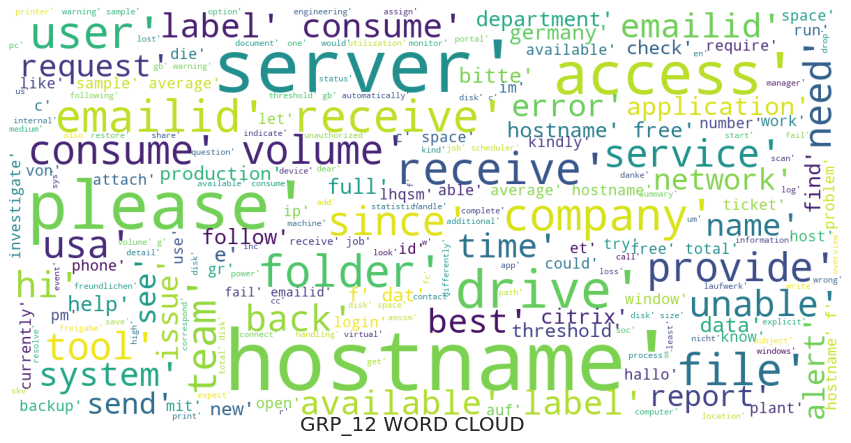

In [ ]:
text_Str1 = incidents_sum['Description_Preprocessed'][incidents_sum['AssignmentGroup'].isin(["GRP_12"])].tolist()
show_wordcloud(text_Str1,"GRP_12 WORD CLOUD" )

In [ ]:
#Word Clouds for some random Groups

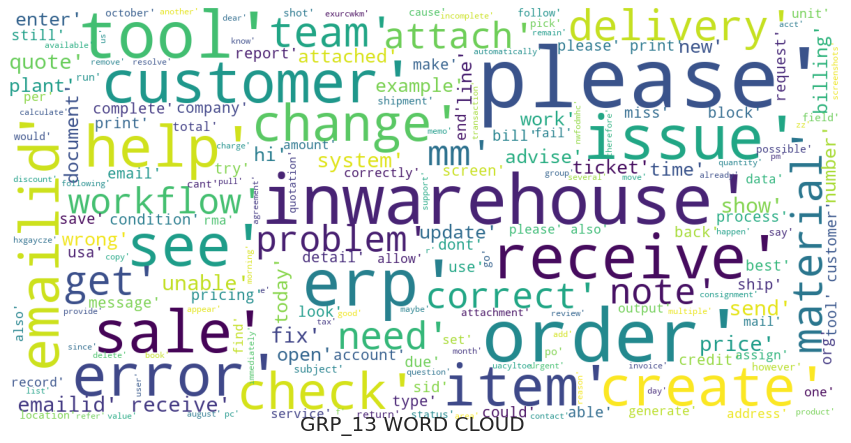

In [ ]:
text_Str1 = incidents_sum['Description_Preprocessed'][incidents_sum['AssignmentGroup'].isin(["GRP_13"])].tolist()
show_wordcloud(text_Str1,"GRP_13 WORD CLOUD" )

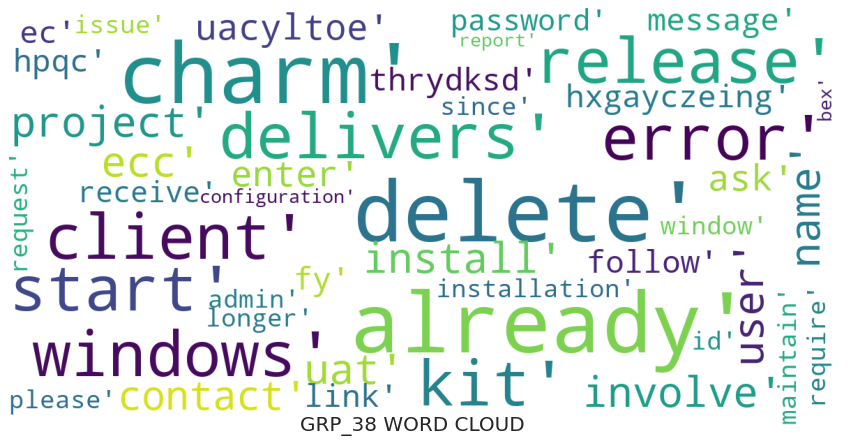

In [ ]:
text_Str1 = incidents_sum['Description_Preprocessed'][incidents_sum['AssignmentGroup'].isin(["GRP_38"])].tolist()
show_wordcloud(text_Str1,"GRP_38 WORD CLOUD" )

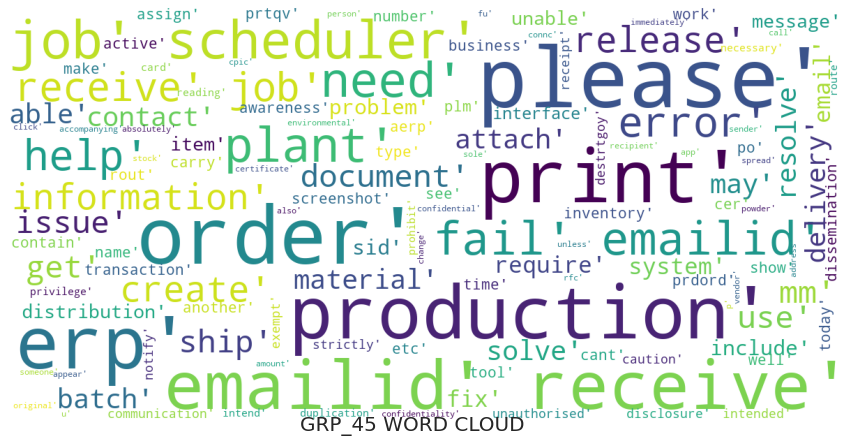

In [ ]:
text_Str1 = incidents_sum['Description_Preprocessed'][incidents_sum['AssignmentGroup'].isin(["GRP_45"])].tolist()
show_wordcloud(text_Str1,"GRP_45 WORD CLOUD" )

In [ ]:
#Word Clouds for some random Groups(Combined)

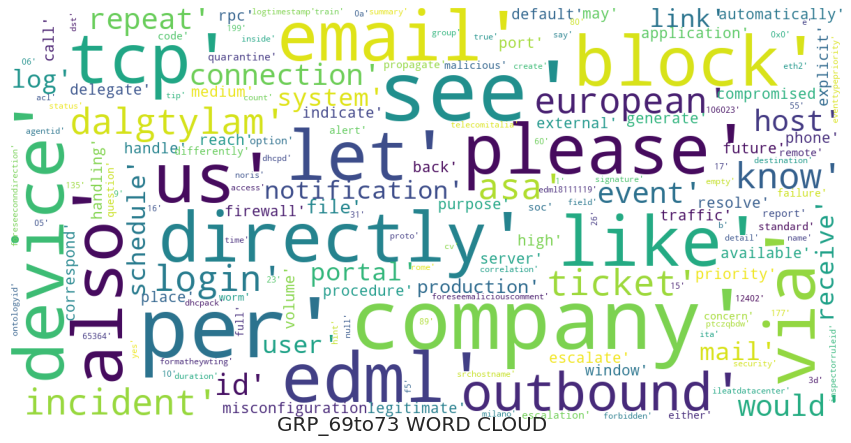

In [ ]:
text_Str1 = incidents_sum['Description_Preprocessed'][incidents_sum['AssignmentGroup'].isin(["GRP_69","GRP_70","GRP_71","GRP_72","GRP_73"])].tolist()
show_wordcloud(text_Str1,"GRP_69to73 WORD CLOUD" )

In [ ]:
## join the list members of the column
incidents_sum1['Description_Preprocessed_upd']=[" ".join(description) for description in incidents_sum1['Description_Preprocessed'].values]

## Removing numbers  if there are any
incidents_sum1['Description_Preprocessed_upd'] = incidents_sum1['Description_Preprocessed_upd'].str.replace('\d+', '')

In [ ]:
incidents_sum1.columns

Index(['Description', 'Caller', 'AssignmentGroup', 'Description_Preprocessed',
       'Cleaned_sent', 'Description_Preprocessed_upd'],
      dtype='object')

In [ ]:
df = incidents_sum1.copy()
df.drop(columns=["Description","Description_Preprocessed"], inplace=True)

In [ ]:
df.columns

Index(['Caller', 'AssignmentGroup', 'Cleaned_sent',
       'Description_Preprocessed_upd'],
      dtype='object')

## **3. Deciding Models and Model Building**

**Model Building**

In [ ]:
df.columns

Index(['Caller', 'AssignmentGroup', 'Cleaned_sent',
       'Description_Preprocessed_upd'],
      dtype='object')

In [ ]:
incidents_sum1['AssignmentGroup'].value_counts()[:40]

GRP_0     3933
GRP_8      645
GRP_24     285
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      183
GRP_13     145
GRP_10     140
GRP_5      128
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_7       68
GRP_17      68
GRP_31      66
GRP_34      62
GRP_26      56
GRP_40      45
GRP_28      44
GRP_41      40
GRP_15      38
GRP_42      37
GRP_20      36
GRP_45      35
GRP_22      31
GRP_1       31
GRP_11      30
GRP_21      28
GRP_47      27
GRP_23      25
GRP_62      25
GRP_30      23
GRP_39      19
Name: AssignmentGroup, dtype: int64

In [ ]:
list(incidents_sum1['AssignmentGroup'].value_counts()[:28].index)

['GRP_0',
 'GRP_8',
 'GRP_24',
 'GRP_12',
 'GRP_9',
 'GRP_2',
 'GRP_19',
 'GRP_3',
 'GRP_6',
 'GRP_13',
 'GRP_10',
 'GRP_5',
 'GRP_14',
 'GRP_25',
 'GRP_33',
 'GRP_4',
 'GRP_29',
 'GRP_18',
 'GRP_16',
 'GRP_7',
 'GRP_17',
 'GRP_31',
 'GRP_34',
 'GRP_26',
 'GRP_40',
 'GRP_28',
 'GRP_41',
 'GRP_15']

In [ ]:
Groups = list(incidents_sum1['AssignmentGroup'].value_counts()[:28].index) #Storing Group names with tickets > 38
print(len(Groups))

28


In [ ]:
## create a column to mark records of Groups with tickets < 38 as GRP_X
incidents_sum1['GRP_MOD1'] = incidents_sum1['AssignmentGroup'].apply(lambda x: 'GRP_X' if x not in Groups else x)

In [ ]:
incidents_sum1['GRP_MOD1'].value_counts()

GRP_0     3933
GRP_8      645
GRP_X      559
GRP_24     285
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      183
GRP_13     145
GRP_10     140
GRP_5      128
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_7       68
GRP_17      68
GRP_31      66
GRP_34      62
GRP_26      56
GRP_40      45
GRP_28      44
GRP_41      40
GRP_15      38
Name: GRP_MOD1, dtype: int64

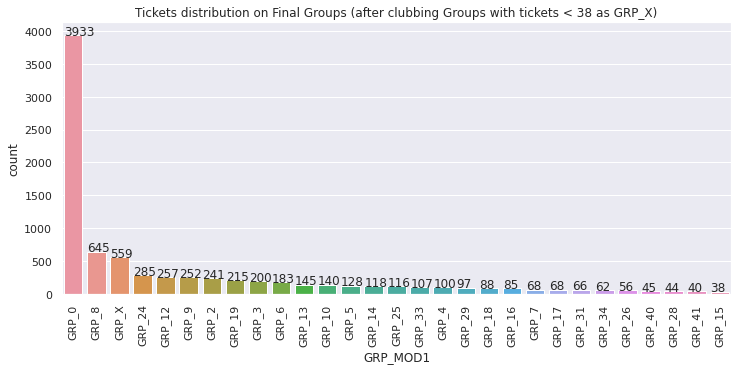

In [ ]:
sns.set(rc={'figure.figsize':(12, 5)})
ax1 = sns.countplot(x="GRP_MOD1", data=incidents_sum1, order = incidents_sum1['GRP_MOD1'].value_counts().index)
for item in ax1.get_xticklabels():
  item.set_rotation(90)

for p in ax1.patches:
  ax1.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+5))

plt.title('Tickets distribution on Final Groups (after clubbing Groups with tickets < 38 as GRP_X)')
plt.show()

In [ ]:
incidents_sum1.shape[0]

8381

In [ ]:
incidents_sum1.to_csv('incidents_sum1.csv',index=False)

In [ ]:
incidents_sum1 = pd.read_csv('/content/drive/MyDrive/AIML_PGP_Projects/Projects/Capstone/incidents_sum1.csv')
print(incidents_sum1.columns)
incidents_sum1.head()

Index(['Description', 'Caller', 'AssignmentGroup', 'Description_Preprocessed',
       'Cleaned_sent', 'Language', 'Accuracy', 'Description_Preprocessed_upd',
       'GRP_MOD1'],
      dtype='object')


Description  ... GRP_MOD1
0  login issue -verified user details.(employee# ...  ...    GRP_0
1  outlook \r\n\r\nreceived from: hmjdrvpb.komuay...  ...    GRP_0
2  cant log in to vpn \r\n\r\nreceived from: eylq...  ...    GRP_0
3  unable to access hr_tool page unable to access...  ...    GRP_0
4                          skype error  skype error   ...    GRP_0

[5 rows x 9 columns]

In [ ]:
incidents_sum1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8381 entries, 0 to 8380
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Description                   8372 non-null   object 
 1   Caller                        8381 non-null   object 
 2   AssignmentGroup               8381 non-null   object 
 3   Description_Preprocessed      8381 non-null   object 
 4   Cleaned_sent                  8372 non-null   object 
 5   Language                      8381 non-null   object 
 6   Accuracy                      8381 non-null   float64
 7   Description_Preprocessed_upd  8372 non-null   object 
 8   GRP_MOD1                      8381 non-null   object 
dtypes: float64(1), object(8)
memory usage: 589.4+ KB


In [ ]:
df = incidents_sum1.copy()
df.columns

Index(['Description', 'Caller', 'AssignmentGroup', 'Description_Preprocessed',
       'Cleaned_sent', 'Description_Preprocessed_upd', 'GRP_MOD1'],
      dtype='object')

In [ ]:
#specifying the field "Description" datatype, (in this case, its string)
df["Description_Preprocessed_upd"] = df["Description_Preprocessed_upd"].astype(str) 

In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

## split the data into Train and Text (0.75)
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['Description_Preprocessed_upd'], df['GRP_MOD1'], test_size=0.25, random_state=42,stratify=df['GRP_MOD1'])

In [ ]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(6285,)
(2096,)
(6285,)
(2096,)


In [ ]:
## encode the GRP_MOD1 data
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

In [ ]:
print(train_y[40])
print(encoder.inverse_transform(train_y)[40])

27
GRP_9


In [ ]:
list(encoder.classes_)

['GRP_0',
 'GRP_10',
 'GRP_12',
 'GRP_13',
 'GRP_14',
 'GRP_15',
 'GRP_16',
 'GRP_17',
 'GRP_18',
 'GRP_19',
 'GRP_2',
 'GRP_24',
 'GRP_25',
 'GRP_26',
 'GRP_28',
 'GRP_29',
 'GRP_3',
 'GRP_31',
 'GRP_33',
 'GRP_34',
 'GRP_4',
 'GRP_40',
 'GRP_41',
 'GRP_5',
 'GRP_6',
 'GRP_7',
 'GRP_8',
 'GRP_9',
 'GRP_X']

In [ ]:
len(list(encoder.classes_))

29

In [ ]:
encoder.inverse_transform(range(0,29))

array(['GRP_0', 'GRP_10', 'GRP_12', 'GRP_13', 'GRP_14', 'GRP_15',
       'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2', 'GRP_24',
       'GRP_25', 'GRP_26', 'GRP_28', 'GRP_29', 'GRP_3', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_4', 'GRP_40', 'GRP_41', 'GRP_5', 'GRP_6',
       'GRP_7', 'GRP_8', 'GRP_9', 'GRP_X'], dtype=object)

In [ ]:
#To see encoded class and its corresponding class label
a = tuple(range(0,29))
b = tuple(encoder.classes_)
class_labels = tuple(zip(a, b))
print(class_labels)

((0, 'GRP_0'), (1, 'GRP_10'), (2, 'GRP_12'), (3, 'GRP_13'), (4, 'GRP_14'), (5, 'GRP_15'), (6, 'GRP_16'), (7, 'GRP_17'), (8, 'GRP_18'), (9, 'GRP_19'), (10, 'GRP_2'), (11, 'GRP_24'), (12, 'GRP_25'), (13, 'GRP_26'), (14, 'GRP_28'), (15, 'GRP_29'), (16, 'GRP_3'), (17, 'GRP_31'), (18, 'GRP_33'), (19, 'GRP_34'), (20, 'GRP_4'), (21, 'GRP_40'), (22, 'GRP_41'), (23, 'GRP_5'), (24, 'GRP_6'), (25, 'GRP_7'), (26, 'GRP_8'), (27, 'GRP_9'), (28, 'GRP_X'))


In [ ]:
tfidf_vect = TfidfVectorizer(min_df=5 ,use_idf=True,analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['Description_Preprocessed_upd'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(test_x)

#tfidf_vect.fit(df['Description_Preprocessed_upd']).values.astype('U')
#xtrain_tfidf =  tfidf_vect.transform(train_x).values.astype('U')
#xvalid_tfidf =  tfidf_vect.transform(test_x).values.astype('U')

In [ ]:
#Creating empty dataframe to append metrics info of models
column_names = ["Model_Name", "Accuracy", "F1_Score","Precision","Recall"]
df_metrics = pd.DataFrame(columns = column_names)
df_metrics

Empty DataFrame
Columns: [Model_Name, Accuracy, F1_Score, Precision, Recall]
Index: []

In [ ]:
## common function(Training the model and Metrics calculation) for Classifiers 
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label) #train the model
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid) #make predictions on test set

    # predict the Probabilities on validation dataset
    probabilities = classifier.predict_proba(feature_vector_valid) #getting prediction probabilities
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    #return metrics.accuracy_score(predictions, test_y)
    return predictions , probabilities

def cal_accuracy(model_name, y_test, y_pred):
    global df_metrics 

    print ("############  Model Used: ",model_name, " ####################")
    print("Confusion Matrix:\n ", metrics.confusion_matrix(y_test, y_pred)) #confusion matrix
    Accuracy = metrics.accuracy_score(y_test,y_pred)*100  
    print ("Accuracy : ", Accuracy) 
    
    #considering average='micro' for precision, recall & f1 scores calculation.
    Recall = metrics.recall_score(y_test, y_pred,average='micro') #recall
    Precision = metrics.precision_score(y_test, y_pred,average='micro') #precision
    f1 = metrics.f1_score(y_test, y_pred,average='micro') #fl score
    print("Recall: {:.2f}".format(Recall))
    print("Precision: {:.2f}".format(Precision))
    print("F1 Score: {:.2f}".format(f1))
      
    print("Report : ", 
    metrics.classification_report(y_test, y_pred))
    df_metrics = df_metrics.append({'Model_Name' : model_name, 'Accuracy' : Accuracy, 'F1_Score' : f1, 'Precision': Precision,
                    'Recall':Recall},  ignore_index = True)

In [ ]:
## ROC Curve common function for multi class Classifiers
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib.cm import get_cmap

#Colors for graph
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = list(cmap.colors)  # type: list
name2 = "tab20b"
cmap2 = get_cmap(name2)
colors2 = list(cmap2.colors)
colors.extend(colors2)

def multi_class_ROC_AUC(model_name, y_test, pred_prob,colors):
  print('_____________ROC AUC Curve___________________')
  print ("############  Model Used: ",model_name, " ####################")
  fpr = {}
  tpr = {}
  thresh ={}
  n_class = len(list(encoder.classes_))
  labels = list(encoder.classes_)

  for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
  #Graph Plotting
  plt.figure(figsize=(20,10), dpi=80)
  for i in range(n_class):
    #plt.plot(fpr[i], tpr[i], linestyle='--',color='orange', label='Class 0 vs Rest')
    plt.plot(fpr[i], tpr[i],color=colors[i],label=labels[i])
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='lower right') #loc ="best"
  #plt.savefig('Multiclass ROC',dpi=300); 

############  Model Used:  Naive Bayes  ####################
Confusion Matrix:
  [[971   0   1   0   0   0   0   0   0   0   0   9   0   0   0   0   0   0
    1   0   0   0   0   0   0   0   1   0   1]
 [ 16   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0  17   0   2]
 [ 33   0  21   0   2   0   0   0   0   0   0   3   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   2   0   3]
 [ 24   0   0   2   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   9]
 [ 21   0   2   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   1   0   3]
 [  9   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [ 21   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [ 17   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

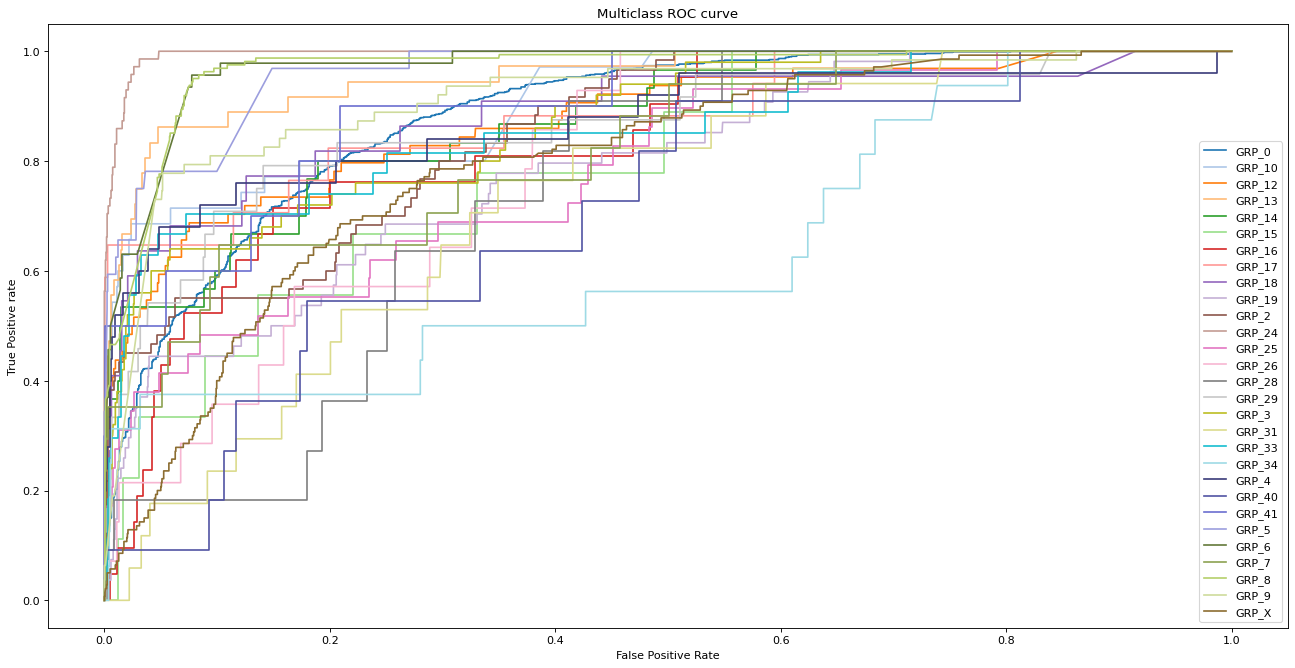

In [ ]:
## naive Bayes
# Naive Bayes on Word Level TF IDF Vectors
model_name = "Naive Bayes"
pred_result, prob_result = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
cal_accuracy (model_name,test_y, pred_result)
#print("NB, WordLevel TF-IDF: ", accuracy)
multi_class_ROC_AUC (model_name,test_y, prob_result,colors)

In [ ]:
df_metrics

Model_Name   Accuracy  F1_Score  Precision   Recall
0  Naive Bayes  59.541985   0.59542    0.59542  0.59542

############  Model Used:  Logistic Regression  ####################
Confusion Matrix:
  [[954   0   3   1   0   0   0   2   0   3   4   1   1   0   0   0   3   0
    0   2   0   0   0   0   1   2   0   0   7]
 [ 10   8   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   9   0   5]
 [ 27   0  28   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   2   0   3]
 [ 16   0   0  15   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   5]
 [ 14   0   3   0   6   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   2   0   5]
 [  6   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   2]
 [ 20   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  6   0   0   0   0   0   0  11   0   0   0   0   0   0   0   

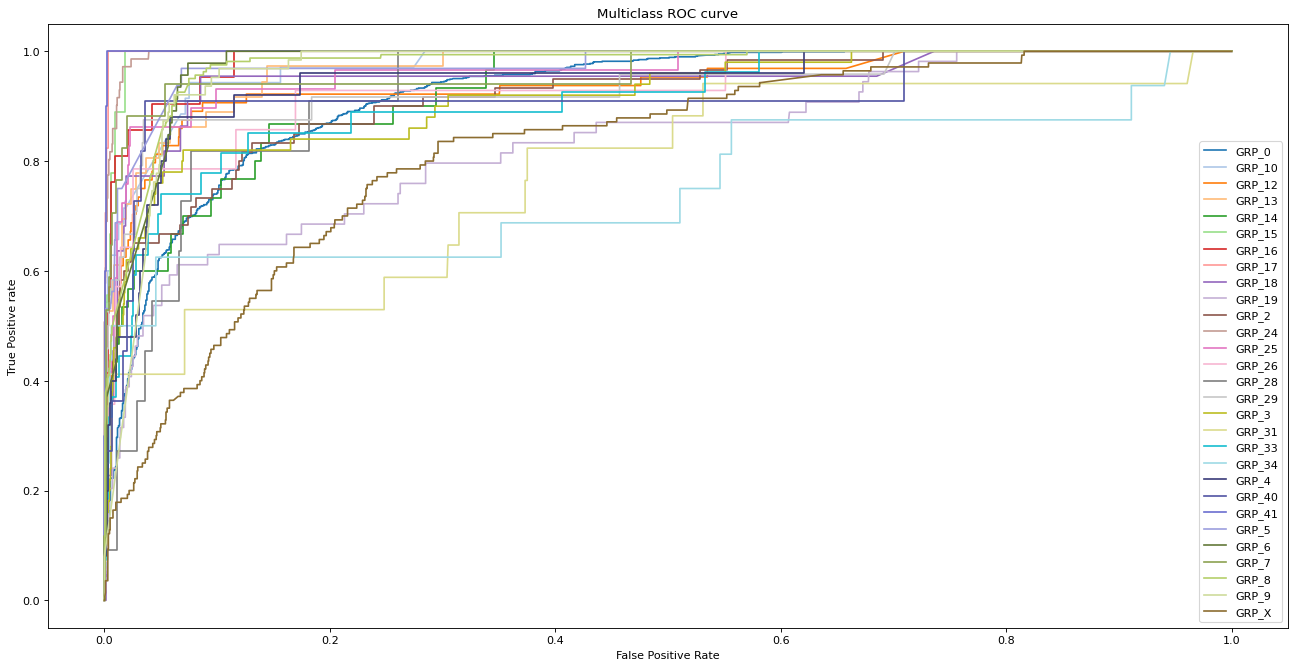

In [ ]:
model_name = "Logistic Regression"
pred_result, prob_result = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
cal_accuracy (model_name,test_y, pred_result)

#accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
#print ("LR, WordLevel TF-IDF: ", accuracy)
multi_class_ROC_AUC (model_name,test_y, prob_result,colors)

############  Model Used:  SVM  ####################
Confusion Matrix:
  [[965   0   1   1   0   0   0   3   0   2   0   0   1   0   0   0   1   0
    0   2   0   0   0   0   1   3   0   0   4]
 [ 17  10   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   6   1   0]
 [ 27   0  31   0   2   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   2   0   1]
 [ 23   0   0  11   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   2]
 [ 17   0   2   0   7   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   2   0   2]
 [  9   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [ 21   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0  15   0   0   0   0   0   0   0   0   0   0
    0 

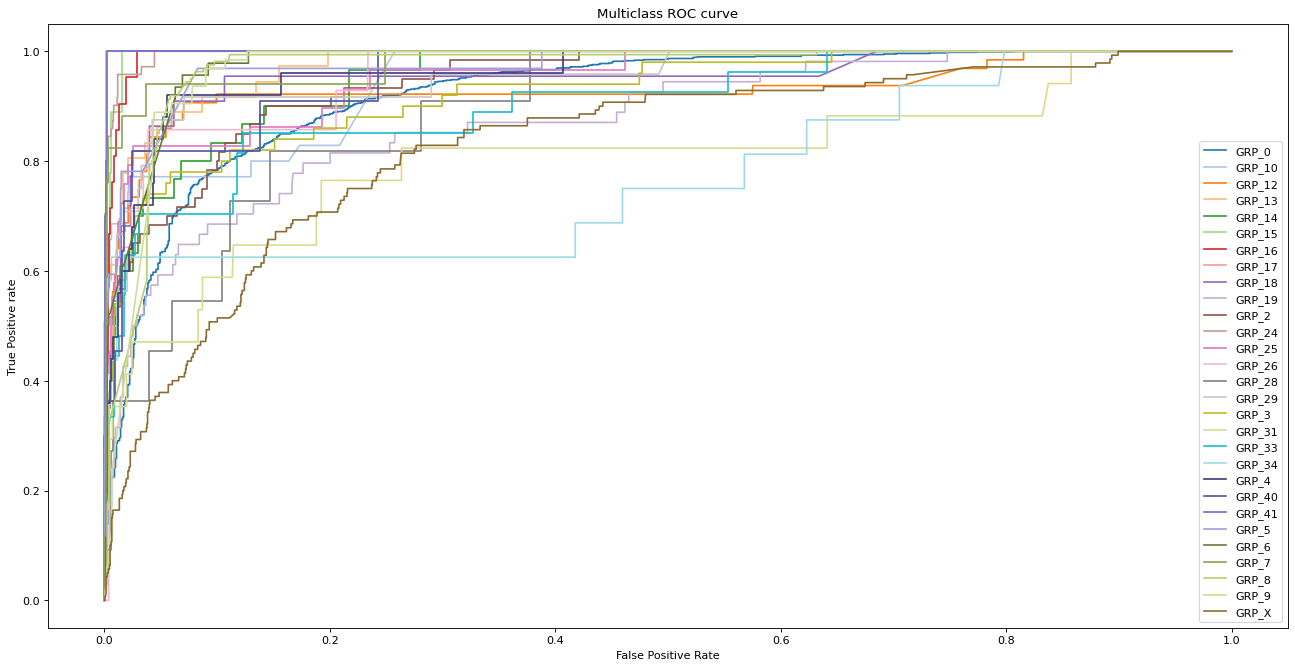

In [ ]:
model_name = "SVM"
pred_result, prob_result = train_model(svm.SVC(probability=True), xtrain_tfidf, train_y, xvalid_tfidf)
#svm.SVC()
cal_accuracy (model_name,test_y, pred_result)

#accuracy = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
#print ("SVM, N-Gram Vectors: ", accuracy)
multi_class_ROC_AUC (model_name,test_y, prob_result,colors)

############  Model Used:  RandomForest  ####################
Confusion Matrix:
  [[939   0   7   1   1   0   0   3   0   8   0   0   3   0   0   0   1   3
    0   3   0   0   0   0   1   3   0   0  11]
 [  9  13   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   6   1   1]
 [ 19   0  40   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   3   0   1]
 [ 14   0   0  19   0   0   0   0   0   0   0   0   0   0   0   2   0   0
    0   0   0   0   0   0   0   0   0   0   1]
 [ 13   0   2   1   9   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   3   0   2]
 [  8   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   1]
 [ 21   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0  14   0   0   0   0   0   0   0   0   0  

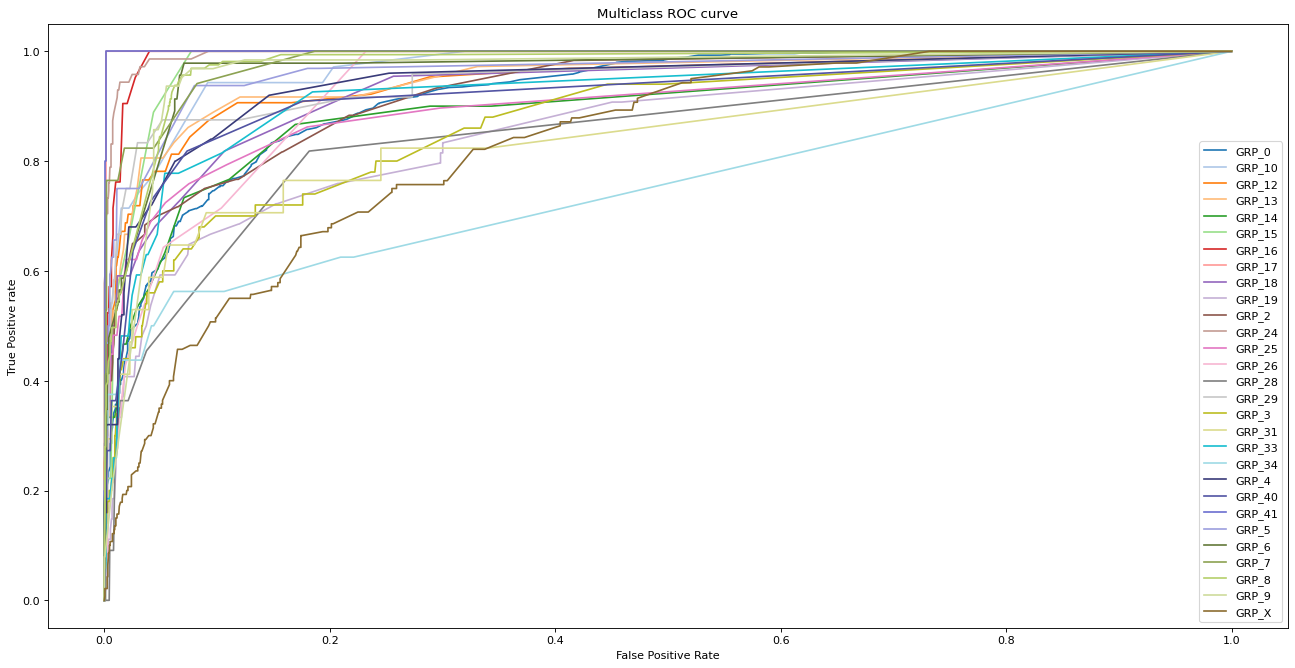

In [ ]:
model_name = "RandomForest"
pred_result, prob_result = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
cal_accuracy (model_name,test_y, pred_result)

#accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
#print ("RF, Count Vectors: ", accuracy)
multi_class_ROC_AUC (model_name,test_y, prob_result,colors)

############  Model Used:  XGBoost Classifier  ####################
Confusion Matrix:
  [[940   0  10   0   1   1   5   3   1   5   3   0   3   0   0   1   0   0
    0   1   0   0   1   1   1   3   0   0   4]
 [ 11  12   0   2   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   8   1   0]
 [ 22   0  35   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   2   0   0   0   0   0   0   2   0   1]
 [ 15   0   0  16   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   4]
 [ 14   0   3   1   7   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   2   0   0   3   0   0]
 [  6   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1   0   0   0   0   0   0   0]
 [  8   0   0   0   0   0  13   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  17   0   0   0   0   0   0   0   0

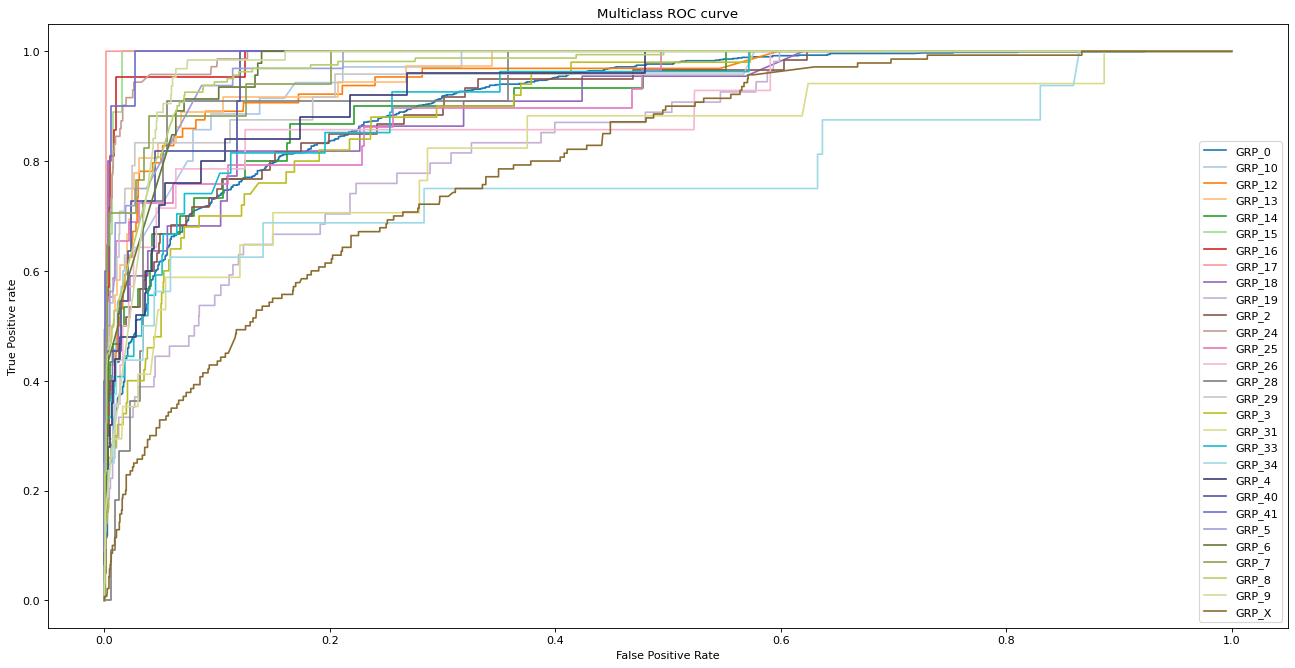

In [ ]:
#XGBoost
from xgboost import XGBClassifier
model_name = "XGBoost Classifier"
pred_result, prob_result = train_model(XGBClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
cal_accuracy (model_name,test_y, pred_result)

#accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
#print ("RF, Count Vectors: ", accuracy)
multi_class_ROC_AUC (model_name,test_y, prob_result,colors)

In [ ]:
df_metrics

Model_Name   Accuracy  F1_Score  Precision    Recall
0          Naive Bayes  59.541985  0.595420   0.595420  0.595420
1  Logistic Regression  64.360687  0.643607   0.643607  0.643607
2                  SVM  64.217557  0.642176   0.642176  0.642176
3         RandomForest  65.839695  0.658397   0.658397  0.658397
4   XGBoost Classifier  65.458015  0.654580   0.654580  0.654580

In [ ]:
#Neural Network

In [ ]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [ ]:
df.columns

Index(['Description', 'Caller', 'AssignmentGroup', 'Description_Preprocessed',
       'Cleaned_sent', 'Description_Preprocessed_upd', 'GRP_MOD1'],
      dtype='object')

In [ ]:
#preparing input data for neural network
train_posts1, test_posts1, train_tags1, test_tags1 =model_selection.train_test_split(df['Description_Preprocessed_upd'].astype(str), df['GRP_MOD1'], random_state=7, test_size = 0.2, shuffle = True,stratify=df['GRP_MOD1'])

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts1) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts1)
x_test = tokenize.texts_to_matrix(test_posts1)

encoder = LabelEncoder()
encoder.fit(train_tags1)
y_train1 = encoder.transform(train_tags1)
y_test1 = encoder.transform(test_tags1)
y_train = encoder.transform(train_tags1)
y_test = encoder.transform(test_tags1)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 20

In [ ]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               512512    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 29)                14877     
_________________________________________________________________
activation_5 (Activation)    (None, 29)                0         
Total params: 527,389
Trainable params: 527,389
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/20
189/189 [==============================] - 1s 3ms/step - loss: 2.3934 - accuracy: 0.4856 - val_loss: 1.4391 - val_accuracy: 0.6095
Epoch 2/20
189/189 [==============================] - 0s 2ms/step - loss: 1.2720 - accuracy: 0.6398 - val_loss: 1.1902 - val_accuracy: 0.6498
Epoch 3/20
189/189 [==============================] - 0s 2ms/step - loss: 0.9737 - accuracy: 0.7226 - val_loss: 1.0922 - val_accuracy: 0.6736
Epoch 4/20
189/189 [==============================] - 0s 2ms/step - loss: 0.8061 - accuracy: 0.7597 - val_loss: 1.0811 - val_accuracy: 0.6841
Epoch 5/20
189/189 [==============================] - 0s 2ms/step - loss: 0.6893 - accuracy: 0.7936 - val_loss: 1.1072 - val_accuracy: 0.6766
Epoch 6/20
189/189 [==============================] - 0s 2ms/step - loss: 0.5857 - accuracy: 0.8248 - val_loss: 1.1078 - val_accuracy: 0.6841
Epoch 7/20
189/189 [==============================] - 0s 2ms/step - loss: 0.5523 - accuracy: 0.8337 - val_loss: 1.1268 - val_accuracy: 0.6811
Epoch 

In [ ]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

53/53 [==============================] - 0s 2ms/step - loss: 1.6018 - accuracy: 0.6726
Test accuracy: 0.672629714012146


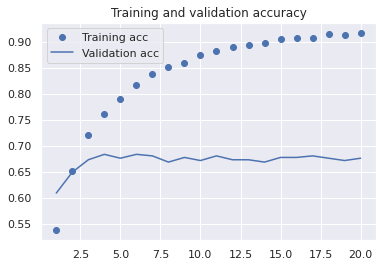

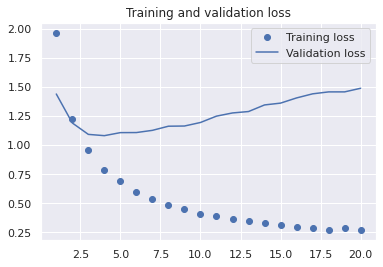

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

############  Model Used:  Neural Networks  ####################
Confusion Matrix:
  [[713   0   5   0   2   0   7   1   1  12   8   1   2   1   1   1   4   1
    1   4   2   1   0   0   0   0   0   0  19]
 [  0  11   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   9   0   6]
 [  7   0  31   0   3   0   0   0   0   0   3   1   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   2   0   3]
 [  3   0   0  19   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   2   0   1   0   4]
 [  7   0   1   0  11   0   0   0   0   1   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   3]
 [  1   0   0   1   0   4   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   1]
 [  6   0   1   0   0   0   9   0   0   0   0   0   0   0   1   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0  13   0   0   0   0   0   0   0   0   

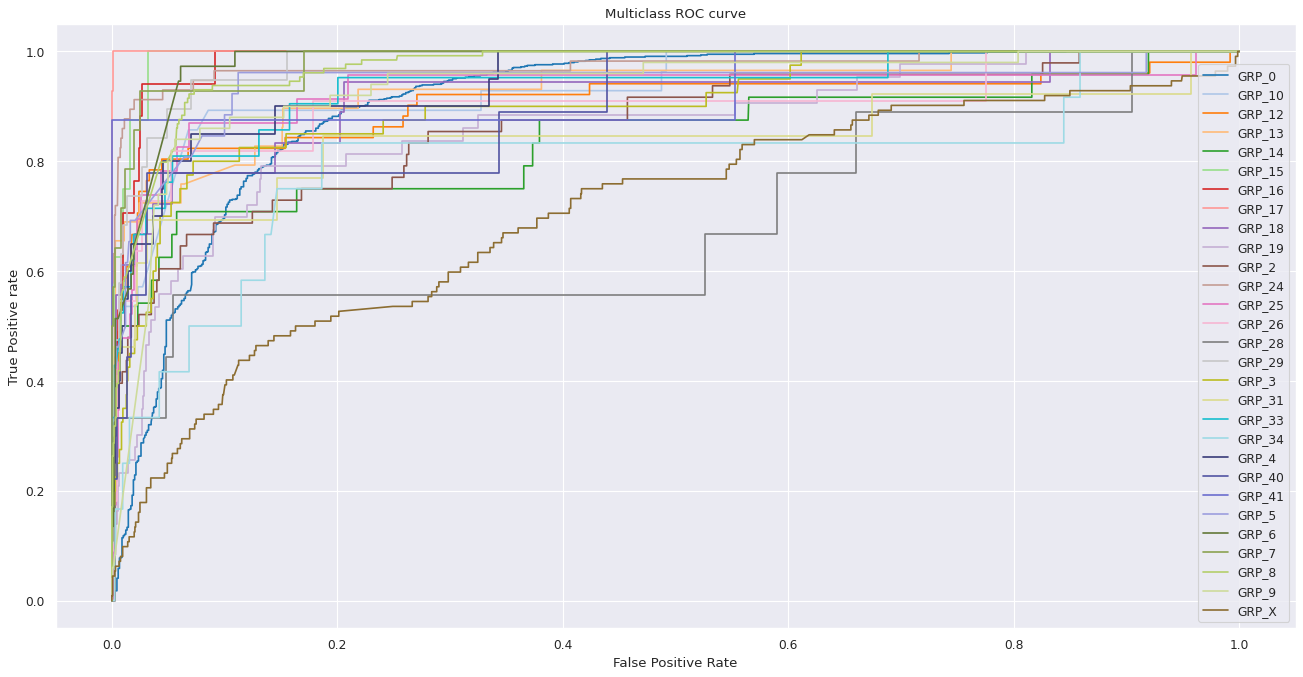

In [ ]:
model_name = 'Neural Networks'
pred_result = model.predict_classes(x_test)
pred_prob = model.predict_proba(x_test)

cal_accuracy (model_name,y_test1, pred_result)
multi_class_ROC_AUC(model_name, y_test1, pred_prob,colors)

In [ ]:
print(x_test.shape)
print(y_test.shape)
print(y_test1.shape)
print(test_tags1.shape)
print(pred_result.shape)
print(pred_prob.shape)

(1677, 1000)
(1677, 29)
(1677,)
(1677,)
(1677,)
(1677, 29)


In [ ]:
print(test_tags1[50])
print(y_test[50])
print(y_test1[50])
print(pred_result[50])
print(pred_prob[50])

GRP_8
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
0
11
[5.33625968e-02 3.36211378e-04 1.85576364e-01 1.84608696e-04
 6.92414324e-06 1.57844952e-05 5.74800242e-06 8.81201334e-09
 1.49523359e-04 2.87724833e-05 1.95825251e-05 6.08477235e-01
 3.64554836e-03 3.06409447e-07 2.86809006e-03 1.05156883e-04
 1.67919025e-05 7.61098490e-05 1.01125404e-01 6.59301830e-03
 1.02093582e-05 6.40399958e-06 2.99872880e-07 1.12767220e-05
 2.26464781e-05 9.11986604e-07 2.42580372e-05 2.86409377e-05
 3.73016596e-02]


In [ ]:
df_metrics #Note:  F1-Score , Precision and recall are calculated using average = ‘micro’

Model_Name   Accuracy  F1_Score  Precision    Recall
0          Naive Bayes  59.541985  0.595420   0.595420  0.595420
1  Logistic Regression  64.360687  0.643607   0.643607  0.643607
2                  SVM  64.217557  0.642176   0.642176  0.642176
3         RandomForest  65.839695  0.658397   0.658397  0.658397
4   XGBoost Classifier  65.458015  0.654580   0.654580  0.654580
5      Neural Networks  67.262970  0.672630   0.672630  0.672630

## Observations:

1) We are using entire dataset (Imbalanced data) on our first cut model.

2) considering 0.5 as benchmark for good precision, recall and f1 score.


**SVM:**

*   Classes 0,7,11,23,26 have good precision, recall and f1 score.
*   Poor predictions on classes 5,6,13,14,21,22.
*   ROC_AUC curves for all the classes are above the random guessing line.


**Random Forest:**

*   Classes 0,2,7,11,26 have good precision, recall and f1 score.
*   Poor predictions on classes 5,6,13,14,21.
*   ROC_AUC curves for all the classes are above the random guessing line.

**Neural Network :**

*   Classes 0,2,3,6,7,11,24,26 have good precision, recall and f1 score.
*   Poor predictions on classes 14,19.
*   ROC_AUC curves for all the classes are above the random guessing line.


3) For classes 0,7,11,26 all models are able to make good predictions.

4) For classes 5,6,13,14,21 the classification models are not able to make good predictions.  Neural network fails for classes 14,19.

5) All the models have good number of true positives on group_0 & group_8 (Note : they do have more incidents compared to other classes).

6) As our dataset is imbalanced, there is a chance that our model could be biased towards the majority classes.

7) For milestone 2, we will do further iterations of modelling, trying various approaches to improve the model's performance.









#**Contd... For milestone2** 

**Trying Undersmapling**

Taking 50 samples from each group and using that data for modelling

In [ ]:
#Loading the prepr0cessed data ()
incidents_sum1 = pd.read_csv('/content/drive/MyDrive/AIML_PGP_Projects/Projects/Capstone/incidents_sum1.csv')
print(incidents_sum1.columns)
incidents_sum1.head()

Index(['Description', 'Caller', 'AssignmentGroup', 'Description_Preprocessed',
       'Cleaned_sent', 'Language', 'Accuracy', 'Description_Preprocessed_upd',
       'GRP_MOD1'],
      dtype='object')


Description  ... GRP_MOD1
0  login issue -verified user details.(employee# ...  ...    GRP_0
1  outlook \r\n\r\nreceived from: hmjdrvpb.komuay...  ...    GRP_0
2  cant log in to vpn \r\n\r\nreceived from: eylq...  ...    GRP_0
3  unable to access hr_tool page unable to access...  ...    GRP_0
4                          skype error  skype error   ...    GRP_0

[5 rows x 9 columns]

In [ ]:
#specifying the field "Description" datatype, (in this case, its string)
incidents_sum1["Description_Preprocessed_upd"] = incidents_sum1["Description_Preprocessed_upd"].astype(str) 

In [ ]:
df = incidents_sum1.copy()
df.columns

Index(['Description', 'Caller', 'AssignmentGroup', 'Description_Preprocessed',
       'Cleaned_sent', 'Language', 'Accuracy', 'Description_Preprocessed_upd',
       'GRP_MOD1'],
      dtype='object')

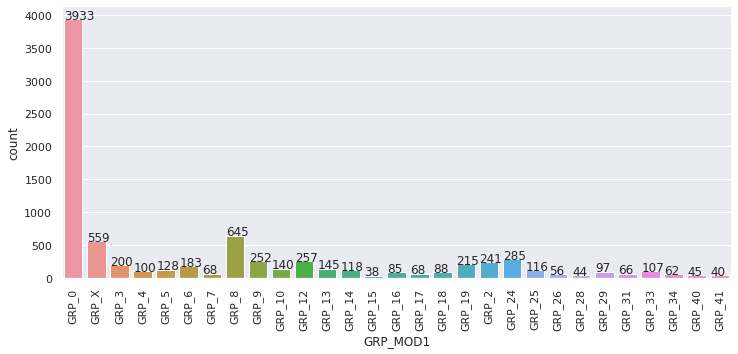

In [ ]:
sns.set(rc={'figure.figsize':(12, 5)})
ax1 = sns.countplot(x="GRP_MOD1", data=incidents_sum1)
for item in ax1.get_xticklabels():
  item.set_rotation(90)

for p in ax1.patches:
  ax1.annotate('{:.0f}'.format(p.get_height()),(p.get_x(),p.get_height()+5))

plt.show()

In [ ]:
#code to randomly select 50 records from each group
#Groups with less than 50 tickets (Taking all those tickets)
G40 = list(incidents_sum1['GRP_MOD1'].value_counts()[25:29].index)
#G40
G50 = list(incidents_sum1['GRP_MOD1'].value_counts()[:25].index)
#G50

df_G40 = incidents_sum1[incidents_sum1.GRP_MOD1.isin(G40)]
#print(df_G40.AssignmentGroup.value_counts())

df_random = pd.DataFrame()
for i in G50:
    data = incidents_sum1[incidents_sum1.GRP_MOD1 == i]
    chosen_idx = np.random.choice(data.shape[0],replace = False, size = 50)
    df2 = data.iloc[chosen_idx]
    df_random=df_random.append(df2,ignore_index=True)

#print(df_random.GRP_MOD1.value_counts())
df_random=df_random.append(df_G40,ignore_index=True) #This is our final undersampled dataset. using this for training the models
print(df_random.GRP_MOD1.value_counts())
#df_random.head()

GRP_10    50
GRP_25    50
GRP_31    50
GRP_3     50
GRP_9     50
GRP_26    50
GRP_0     50
GRP_5     50
GRP_13    50
GRP_4     50
GRP_7     50
GRP_17    50
GRP_14    50
GRP_34    50
GRP_6     50
GRP_18    50
GRP_12    50
GRP_33    50
GRP_2     50
GRP_19    50
GRP_24    50
GRP_X     50
GRP_8     50
GRP_16    50
GRP_29    50
GRP_40    45
GRP_28    44
GRP_41    40
GRP_15    38
Name: GRP_MOD1, dtype: int64


In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
## split the data into Train and Text (0.75)
#train_x, test_x, train_y, test_y = model_selection.train_test_split(df['Description_Preprocessed_upd'], df['GRP_MOD1'], test_size=0.25, random_state=42,stratify=df['GRP_MOD1'])
train_x, test_x, train_y, test_y = model_selection.train_test_split(df_random['Description_Preprocessed_upd'], df_random['GRP_MOD1'], test_size=0.25, random_state=42,stratify=df_random['GRP_MOD1'])

In [ ]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(1062,)
(355,)
(1062,)
(355,)


In [ ]:
## encode the GRP_X and GRP_0 variable

encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

In [ ]:
print(train_y[40])
print(encoder.inverse_transform(train_y)[40])

17
GRP_31


In [ ]:
#To see encoded class and its corresponding class label
a = tuple(range(0,29))
b = tuple(encoder.classes_)
class_labels = tuple(zip(a, b))
print(class_labels)

((0, 'GRP_0'), (1, 'GRP_10'), (2, 'GRP_12'), (3, 'GRP_13'), (4, 'GRP_14'), (5, 'GRP_15'), (6, 'GRP_16'), (7, 'GRP_17'), (8, 'GRP_18'), (9, 'GRP_19'), (10, 'GRP_2'), (11, 'GRP_24'), (12, 'GRP_25'), (13, 'GRP_26'), (14, 'GRP_28'), (15, 'GRP_29'), (16, 'GRP_3'), (17, 'GRP_31'), (18, 'GRP_33'), (19, 'GRP_34'), (20, 'GRP_4'), (21, 'GRP_40'), (22, 'GRP_41'), (23, 'GRP_5'), (24, 'GRP_6'), (25, 'GRP_7'), (26, 'GRP_8'), (27, 'GRP_9'), (28, 'GRP_X'))


In [ ]:
tfidf_vect = TfidfVectorizer(min_df=5 ,use_idf=True,analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['Description_Preprocessed_upd'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(test_x)

#tfidf_vect.fit(df['Description_Preprocessed_upd']).values.astype('U')
#xtrain_tfidf =  tfidf_vect.transform(train_x).values.astype('U')
#xvalid_tfidf =  tfidf_vect.transform(test_x).values.astype('U')

In [ ]:
#Creating empty dataframe to append metrics info of models
column_names = ["Model_Name", "Accuracy", "F1_Score","Precision","Recall"]
df_metrics_undersampled = pd.DataFrame(columns = column_names)
df_metrics_undersampled

Empty DataFrame
Columns: [Model_Name, Accuracy, F1_Score, Precision, Recall]
Index: []

In [ ]:
## common function(Training the model and Metrics calculation) for Classifiers 
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label) #train the model
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid) #make predictions on test set

    # predict the Probabilities on validation dataset
    probabilities = classifier.predict_proba(feature_vector_valid) #getting prediction probabilities
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    #return metrics.accuracy_score(predictions, test_y)
    return predictions , probabilities

def cal_accuracy(model_name, y_test, y_pred):
    global df_metrics_undersampled 

    print ("############  Model Used: ",model_name, " ####################")
    print("Confusion Matrix:\n ", metrics.confusion_matrix(y_test, y_pred)) #confusion matrix
    Accuracy = metrics.accuracy_score(y_test,y_pred)*100  
    print ("Accuracy : ", Accuracy) 
    
    #considering average='micro' for precision, recall & f1 scores calculation.
    Recall = metrics.recall_score(y_test, y_pred,average='micro') #recall
    Precision = metrics.precision_score(y_test, y_pred,average='micro') #precision
    f1 = metrics.f1_score(y_test, y_pred,average='micro') #fl score
    print("Recall: {:.2f}".format(Recall))
    print("Precision: {:.2f}".format(Precision))
    print("F1 Score: {:.2f}".format(f1))
      
    print("Report : ", 
    metrics.classification_report(y_test, y_pred))
    df_metrics_undersampled = df_metrics_undersampled.append({'Model_Name' : model_name, 'Accuracy' : Accuracy, 'F1_Score' : f1, 'Precision': Precision,
                    'Recall':Recall},  ignore_index = True)

In [ ]:
## ROC Curve common function for multi class Classifiers
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib.cm import get_cmap

#Colors for graph
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = list(cmap.colors)  # type: list
name2 = "tab20b"
cmap2 = get_cmap(name2)
colors2 = list(cmap2.colors)
colors.extend(colors2)

def multi_class_ROC_AUC(model_name, y_test, pred_prob,colors):
  print('_____________ROC AUC Curve_Undersampled Data___________________')
  print ("############  Model Used: ",model_name, " ####################")
  fpr = {}
  tpr = {}
  thresh ={}
  n_class = len(list(encoder.classes_))
  labels = list(encoder.classes_)

  for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
  #Graph Plotting
  plt.figure(figsize=(20,10), dpi=80)
  for i in range(n_class):
    #plt.plot(fpr[i], tpr[i], linestyle='--',color='orange', label='Class 0 vs Rest')
    plt.plot(fpr[i], tpr[i],color=colors[i],label=labels[i])
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='lower right') #loc ="best"
  #plt.savefig('Multiclass ROC',dpi=300); 

############  Model Used:  Naive Bayes  ####################
Confusion Matrix:
  [[ 2  0  0  0  0  0  2  1  0  1  1  0  1  1  1  0  0  0  0  1  0  1  0  0
   0  0  0  0  0]
 [ 0  4  0  4  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0  0  1  0]
 [ 0  0  5  0  3  0  1  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  1  0]
 [ 1  0  0  8  0  0  1  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 1  0  2  0  4  0  0  0  1  0  0  0  1  1  0  1  0  0  0  1  0  0  0  1
   0  0  0  0  0]
 [ 0  0  0  2  0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  1  0  3  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 1  0  0  0  0  0  2  0  1  2  0  0  0  2  0  0  4  0  0  0  0  0  0  0
   0  0  0  0  0]

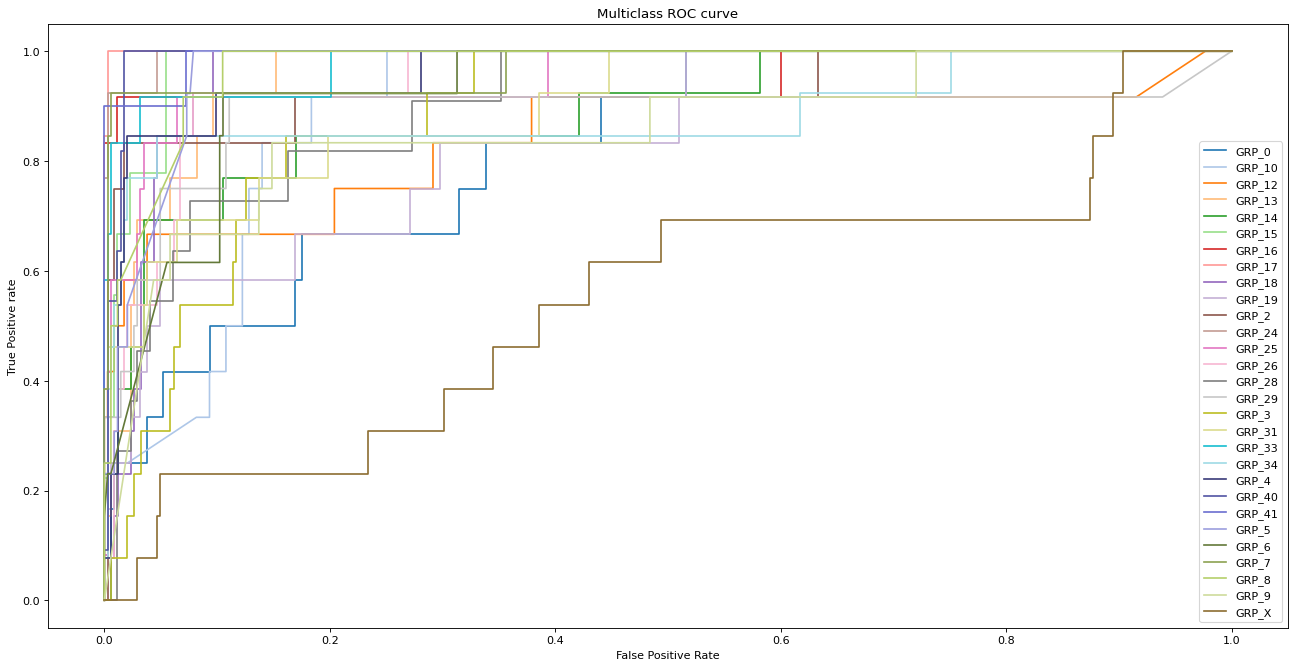

In [ ]:
## naive Bayes
# Naive Bayes on Word Level TF IDF Vectors
model_name = "Naive Bayes"
pred_result, prob_result = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
cal_accuracy (model_name,test_y, pred_result)
#print("NB, WordLevel TF-IDF: ", accuracy)
multi_class_ROC_AUC (model_name,test_y, prob_result,colors)

############  Model Used:  Logistic Regression  ####################
Confusion Matrix:
  [[ 3  0  0  0  0  0  1  1  0  1  1  0  1  1  1  0  0  0  0  1  0  1  0  0
   0  0  0  0  0]
 [ 0  3  0  4  0  0  0  0  1  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1  0]
 [ 1  0  6  0  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  1  0]
 [ 1  0  0  8  0  0  1  0  2  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 1  0  3  0  3  0  0  0  1  0  1  0  0  1  0  1  0  0  0  1  1  0  0  0
   0  0  0  0  0]
 [ 0  0  0  2  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  1  0  3  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  1  2  0  0  0  2  0  0  4  1  0  0  0  0  0  0
   0  0  

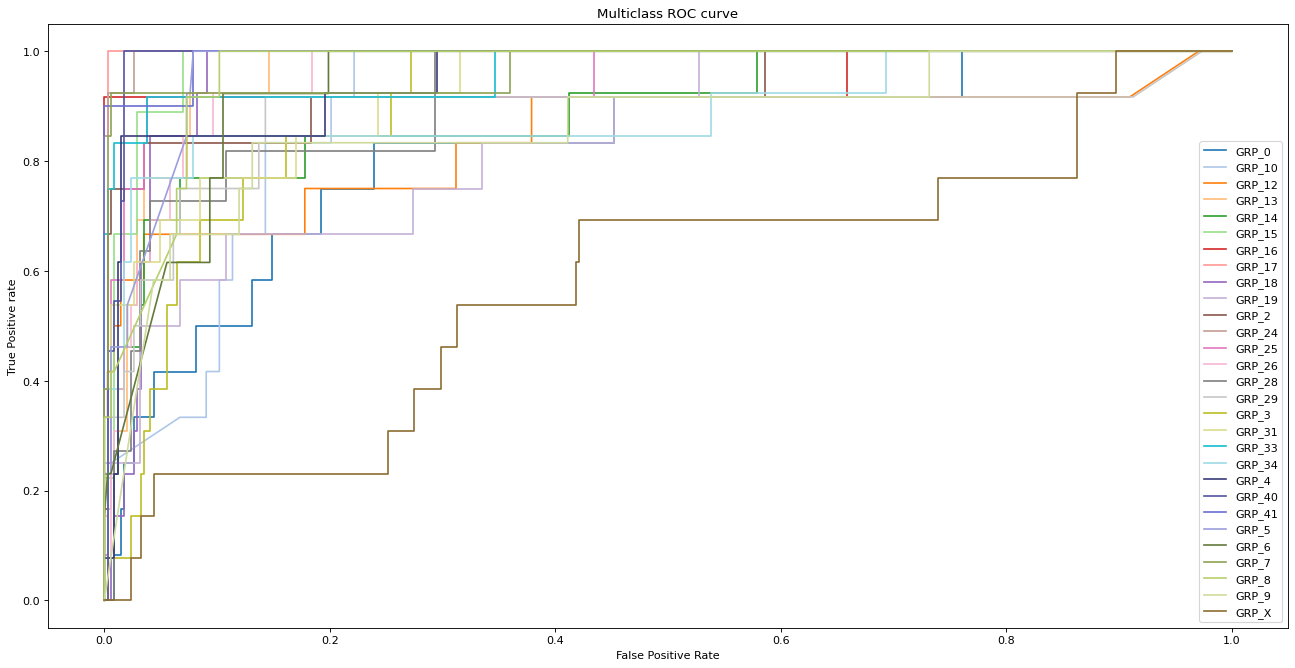

In [ ]:
model_name = "Logistic Regression"
pred_result, prob_result = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
cal_accuracy (model_name,test_y, pred_result)

#accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
#print ("LR, WordLevel TF-IDF: ", accuracy)
multi_class_ROC_AUC (model_name,test_y, prob_result,colors)

############  Model Used:  SVM  ####################
Confusion Matrix:
  [[ 2  0  0  0  0  0  0  0  0  4  1  0  1  1  1  0  0  0  0  1  0  1  0  0
   0  0  0  0  0]
 [ 1  3  0  4  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1  0]
 [ 2  0  7  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  1  0]
 [ 2  0  0  9  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 1  0  3  0  2  0  0  0  1  1  1  0  0  0  0  1  0  0  0  1  0  0  0  0
   0  0  0  0  2]
 [ 0  0  0  2  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
   0  0  0  0  0]
 [ 1  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  7  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  1  2  0  0  0  1  0  0  5  0  0  0  0  0  0  0
   0  0  0  0  1]
 [ 1  0

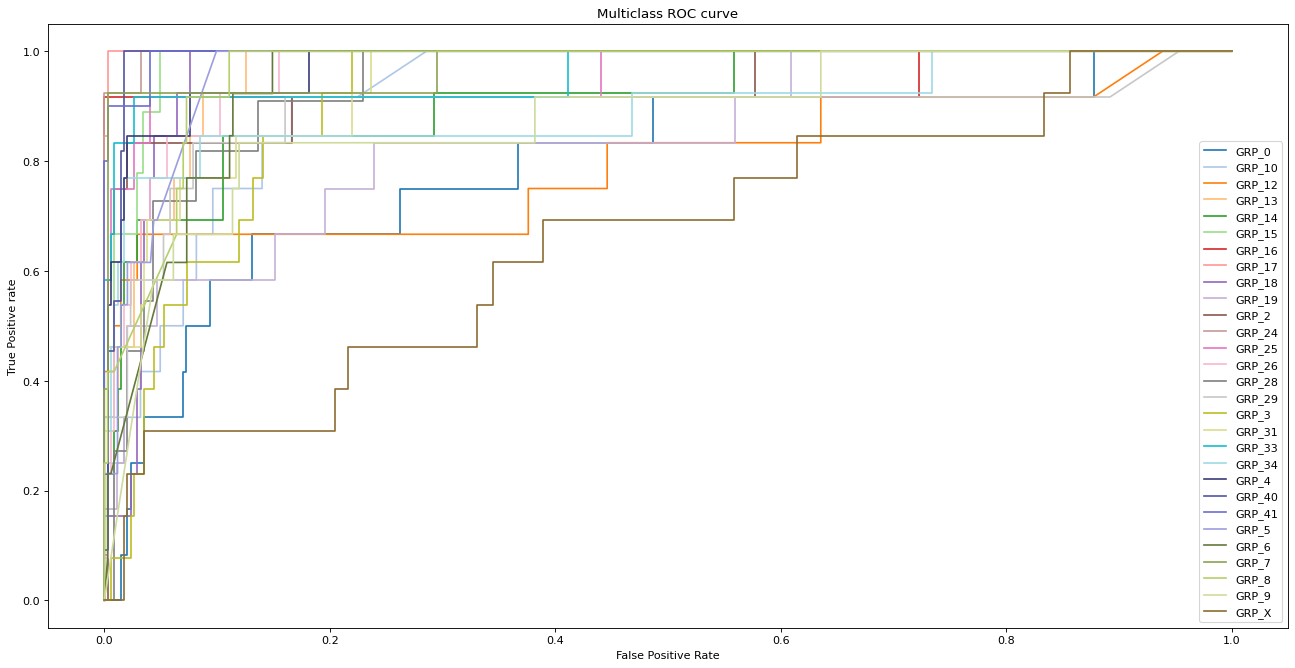

In [ ]:
model_name = "SVM"
pred_result, prob_result = train_model(svm.SVC(probability=True), xtrain_tfidf, train_y, xvalid_tfidf)
#svm.SVC()
cal_accuracy (model_name,test_y, pred_result)

#accuracy = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
#print ("SVM, N-Gram Vectors: ", accuracy)
multi_class_ROC_AUC (model_name,test_y, prob_result,colors)

############  Model Used:  RandomForest  ####################
Confusion Matrix:
  [[ 0  0  0  0  0  0  2  0  1  1  1  0  1  3  1  0  0  2  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  3  0  3  0  0  0  0  0  0  1  0  1  0  0  0  0  1  0  0  0  0  0  0
   0  0  0  1  2]
 [ 1  0  7  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  1  0]
 [ 0  0  0  5  0  0  0  0  4  0  0  0  0  1  0  0  0  3  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  4  0  3  0  1  0  1  0  2  0  1  0  0  0  0  1  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  2  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  1  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 1  1  0  1  0  0  0  0  6  1  0  0  0  0  0  3  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 1  0  0  0  0  1  0  0  0  1  0  1  0  1  0  0  5  0  1  0  0  0  0  0
   0  0  0  0  1

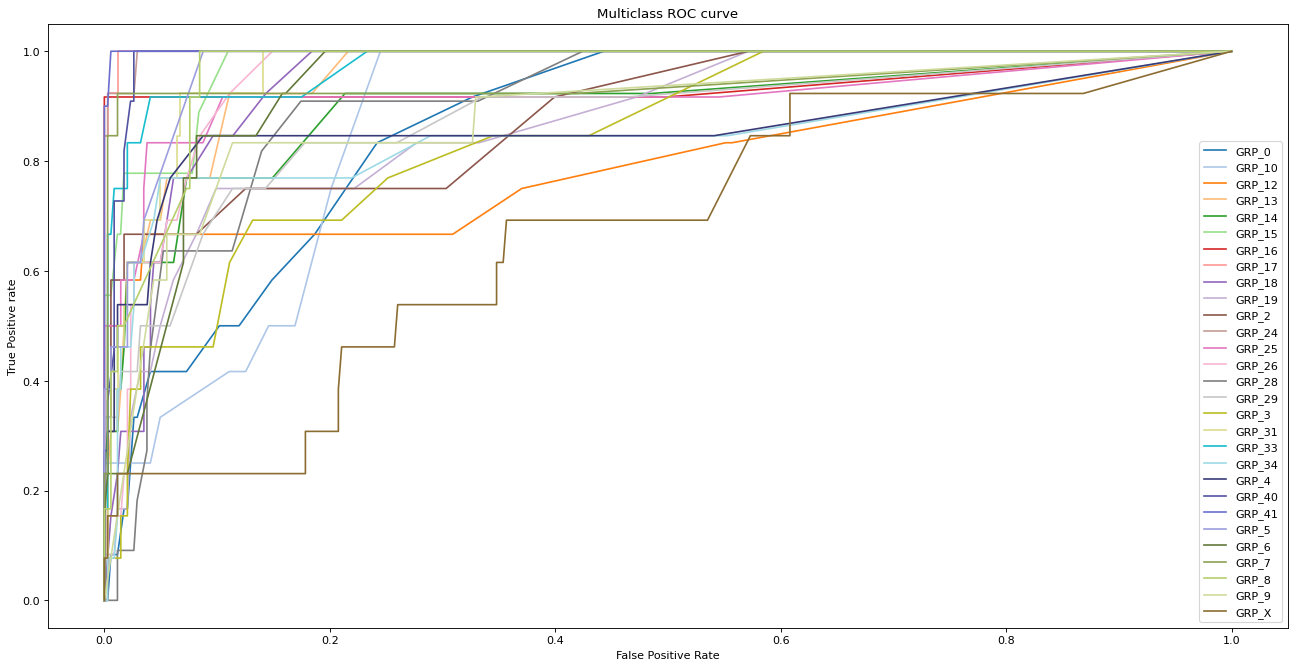

In [ ]:
model_name = "RandomForest"
pred_result, prob_result = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
cal_accuracy (model_name,test_y, pred_result)

#accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
#print ("RF, Count Vectors: ", accuracy)
multi_class_ROC_AUC (model_name,test_y, prob_result,colors)

############  Model Used:  XGBoost Classifier  ####################
Confusion Matrix:
  [[ 1  0  0  0  1  0  0  1  1  2  0  0  1  2  1  0  0  1  0  0  0  0  0  0
   0  0  0  0  1]
 [ 2  3  0  2  0  1  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0
   1  0  0  1  0]
 [ 0  0  6  0  1  0  0  0  0  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  1  1  0]
 [ 0  1  1  2  0  0  0  0  3  0  0  0  1  1  0  1  0  2  0  0  1  0  0  0
   0  0  0  0  0]
 [ 1  1  4  0  3  0  0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0]
 [ 0  0  0  1  0  2  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  5  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  1  0  0  0  0  0  2  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
   0  0  0  0  0]
 [ 2  1  0  1  0  0  0  0  4  2  0  0  0  0  0  2  0  0  0  1  0  0  0  0
   0  0  0  0  0]
 [ 1  1  1  0  0  0  0  0  0  2  0  0  0  3  0  0  2  0  2  0  0  0  0  0
   0  0  0

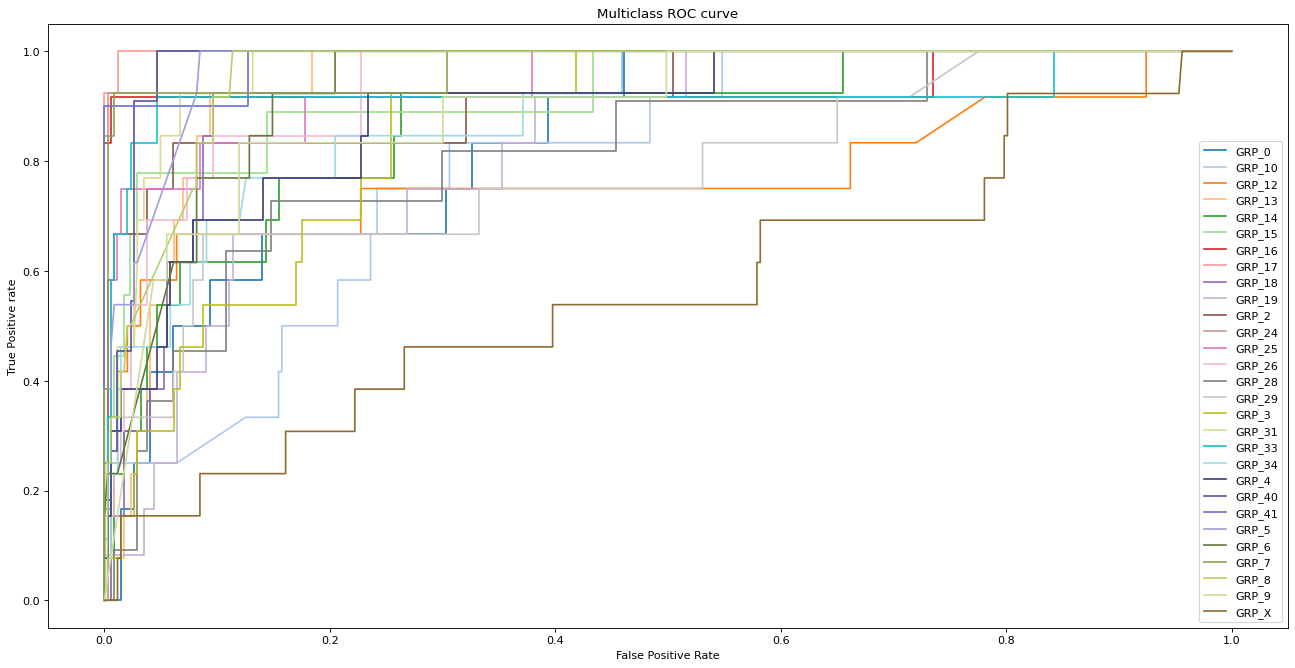

In [ ]:
#XGBoost
from xgboost import XGBClassifier
model_name = "XGBoost Classifier"
pred_result, prob_result = train_model(XGBClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
cal_accuracy (model_name,test_y, pred_result)

#accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
#print ("RF, Count Vectors: ", accuracy)
multi_class_ROC_AUC (model_name,test_y, prob_result,colors)

In [ ]:
df_metrics_undersampled

Model_Name   Accuracy  F1_Score  Precision    Recall
0          Naive Bayes  52.676056  0.526761   0.526761  0.526761
1  Logistic Regression  53.802817  0.538028   0.538028  0.538028
2                  SVM  50.985915  0.509859   0.509859  0.509859
3         RandomForest  49.577465  0.495775   0.495775  0.495775
4   XGBoost Classifier  45.633803  0.456338   0.456338  0.456338

In [ ]:
#Neural Network
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from tensorflow.keras import utils

In [ ]:
df.columns

Index(['Description', 'Caller', 'AssignmentGroup', 'Description_Preprocessed',
       'Cleaned_sent', 'Language', 'Accuracy', 'Description_Preprocessed_upd',
       'GRP_MOD1'],
      dtype='object')

In [ ]:
#preparing input data for neural network
train_posts1, test_posts1, train_tags1, test_tags1 =model_selection.train_test_split(df_random['Description_Preprocessed_upd'].astype(str), df_random['GRP_MOD1'], random_state=7, test_size = 0.2, shuffle = True,stratify=df_random['GRP_MOD1'])

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts1) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts1)
x_test = tokenize.texts_to_matrix(test_posts1)

encoder = LabelEncoder()
encoder.fit(train_tags1)
y_train1 = encoder.transform(train_tags1)
y_test1 = encoder.transform(test_tags1)
y_train = encoder.transform(train_tags1)
y_test = encoder.transform(test_tags1)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 20

In [ ]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                14877     
_________________________________________________________________
activation_1 (Activation)    (None, 29)                0         
Total params: 527,389
Trainable params: 527,389
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/20
32/32 [==============================] - 14s 16ms/step - loss: 3.3071 - accuracy: 0.0926 - val_loss: 3.0619 - val_accuracy: 0.3421
Epoch 2/20
32/32 [==============================] - 0s 3ms/step - loss: 2.8219 - accuracy: 0.4539 - val_loss: 2.6869 - val_accuracy: 0.4474
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 2.2697 - accuracy: 0.6742 - val_loss: 2.3143 - val_accuracy: 0.4737
Epoch 4/20
32/32 [==============================] - 0s 3ms/step - loss: 1.8027 - accuracy: 0.7366 - val_loss: 2.0190 - val_accuracy: 0.5175
Epoch 5/20
32/32 [==============================] - 0s 3ms/step - loss: 1.4183 - accuracy: 0.7761 - val_loss: 1.8372 - val_accuracy: 0.5263
Epoch 6/20
32/32 [==============================] - 0s 3ms/step - loss: 1.1345 - accuracy: 0.8002 - val_loss: 1.6919 - val_accuracy: 0.5614
Epoch 7/20
32/32 [==============================] - 0s 3ms/step - loss: 0.9111 - accuracy: 0.8415 - val_loss: 1.5956 - val_accuracy: 0.5702
Epoch 8/20
32/32 [

In [ ]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

9/9 [==============================] - 0s 2ms/step - loss: 1.7332 - accuracy: 0.5387
Test accuracy: 0.5387324094772339


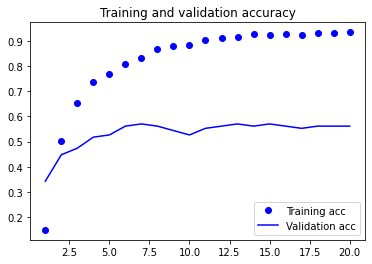

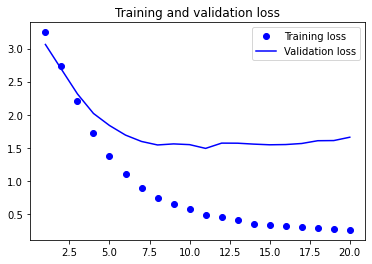

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

############  Model Used:  Neural Networks  ####################
Confusion Matrix:
  [[ 2  0  0  0  0  0  2  0  0  2  0  0  1  0  0  0  0  1  0  0  0  1  0  0
   0  0  0  0  1]
 [ 0  6  0  1  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1  0]
 [ 0  0  0  4  0  2  0  0  1  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0
   1  0  0  0  0]
 [ 1  0  2  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
   0  0  0  0  1]
 [ 0  0  0  0  0  7  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  1  0  3  0  0  0  0  4  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  4  0  1  0  1  1  0  0  0  0  0  0
   0  1  0  0

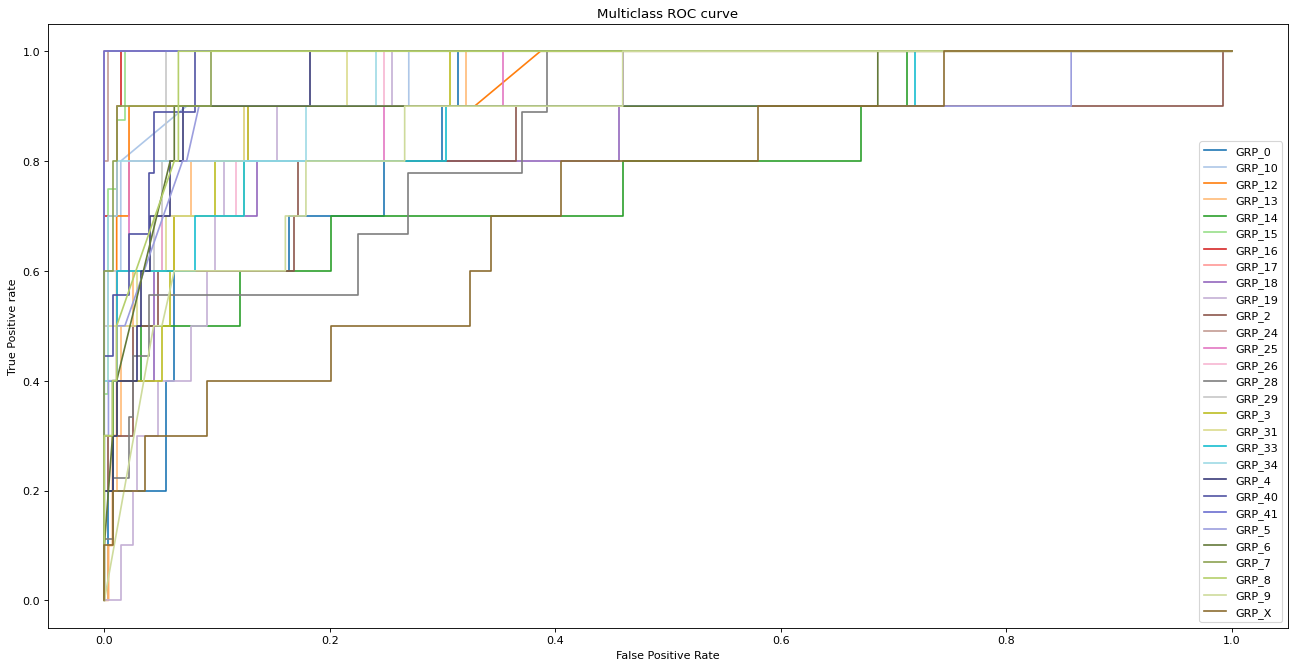

In [ ]:
model_name = 'Neural Networks'
pred_result = model.predict_classes(x_test)
pred_prob = model.predict_proba(x_test)

cal_accuracy (model_name,y_test1, pred_result)
multi_class_ROC_AUC(model_name, y_test1, pred_prob,colors)

In [ ]:
df_metrics_undersampled #Note:  F1-Score , Precision and recall are calculated using average = ‘micro’

Model_Name   Accuracy  F1_Score  Precision    Recall
0          Naive Bayes  52.676056  0.526761   0.526761  0.526761
1  Logistic Regression  53.802817  0.538028   0.538028  0.538028
2                  SVM  50.985915  0.509859   0.509859  0.509859
3         RandomForest  49.577465  0.495775   0.495775  0.495775
4   XGBoost Classifier  45.633803  0.456338   0.456338  0.456338
5      Neural Networks  53.873239  0.538732   0.538732  0.538732

The original data as-is used into the models will have a higher bias towards majority sample classes such as GRP_0, GRP_8 etc, so its not a good apporach.

Our next approach was to undersample the higher sample classes to reduce the bias, this gaves us low accuracy.

So we will try to imporove our approach.

First step would be to upsample the lower samples so that all the classes will be similarly represented, we will use Data Augmentation using nlpaug library to upsample the lower classes.

Finally we will come up a model to train this data for optimum accuracy.

**Data Augmentation - NN with Glove**

In [ ]:
from sklearn.model_selection import train_test_split
import math

from random import sample

In [ ]:
incidents_sum1 = pd.read_csv('/content/drive/MyDrive/CAPSTONE_AIML/Models/combined/incidents_sum1.csv')

In [ ]:
incidents_sum1.head(2)

Description  ... GRP_MOD1
0  login issue -verified user details.(employee# ...  ...    GRP_0
1  outlook \r\n\r\nreceived from: hmjdrvpb.komuay...  ...    GRP_0

[2 rows x 9 columns]

In [ ]:
incidents_sum1['GRP_MOD1'].value_counts()

GRP_0     3933
GRP_8      645
GRP_X      559
GRP_24     285
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      183
GRP_13     145
GRP_10     140
GRP_5      128
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_17      68
GRP_7       68
GRP_31      66
GRP_34      62
GRP_26      56
GRP_40      45
GRP_28      44
GRP_41      40
GRP_15      38
Name: GRP_MOD1, dtype: int64

In [ ]:
dfr_40 = incidents_sum1

In [ ]:

ex = ['GRP_41', 'GRP_15']
dfr_40['ngrp'] = incidents_sum1['GRP_MOD1'].apply(lambda x: 'GRP_X' if x in ex else x)

In [ ]:
dfr_40.head(2)

Description  ...   ngrp
0  login issue -verified user details.(employee# ...  ...  GRP_0
1  outlook \r\n\r\nreceived from: hmjdrvpb.komuay...  ...  GRP_0

[2 rows x 10 columns]

In [ ]:
dfr_40['ngrp'].value_counts()

GRP_0     3933
GRP_8      645
GRP_X      637
GRP_24     285
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      183
GRP_13     145
GRP_10     140
GRP_5      128
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_17      68
GRP_7       68
GRP_31      66
GRP_34      62
GRP_26      56
GRP_40      45
GRP_28      44
Name: ngrp, dtype: int64

If we conside the entire data set for Augmentation then it is going to cause Data leakage, as we are going to boost the lower samples, there is a high probability that Augmented data can be similar to original data. So the test data can be exposed to the model in the Training stage causing it to overfit. To avoid it we are going to split into train and test sets and use the train set for Data Augmentation and then use the test set for Test validation once we train our model

In [ ]:
train_set, test_set = train_test_split(dfr_40, random_state=6, test_size = 0.2, stratify = dfr_40['ngrp'])

In [ ]:
dfr_40.shape

(8381, 10)

In [ ]:
print (train_set.shape, test_set.shape)

(6704, 10) (1677, 10)


In [ ]:
dfr_40['ngrp'].value_counts()

GRP_0     3933
GRP_8      645
GRP_X      637
GRP_24     285
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      183
GRP_13     145
GRP_10     140
GRP_5      128
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_17      68
GRP_7       68
GRP_31      66
GRP_34      62
GRP_26      56
GRP_40      45
GRP_28      44
Name: ngrp, dtype: int64

In [ ]:
test_set['ngrp'].value_counts()

GRP_0     787
GRP_8     129
GRP_X     128
GRP_24     57
GRP_12     51
GRP_9      50
GRP_2      48
GRP_19     43
GRP_3      40
GRP_6      37
GRP_13     29
GRP_10     28
GRP_5      26
GRP_14     24
GRP_25     23
GRP_33     21
GRP_4      20
GRP_29     19
GRP_18     18
GRP_16     17
GRP_7      14
GRP_17     14
GRP_31     13
GRP_34     12
GRP_26     11
GRP_28      9
GRP_40      9
Name: ngrp, dtype: int64

In [ ]:
test = pd.DataFrame()
test['aug_data'] = test_set['Cleaned_sent']
test['grp'] = test_set['ngrp']

In [ ]:
test.head(2)

aug_data    grp
5572  matghyuthdw chain signin receive work please r...  GRP_0
7246  dsw hostname failure rule related ticket com d...  GRP_2

In [ ]:
test['grp'].value_counts()

GRP_0     787
GRP_8     129
GRP_X     128
GRP_24     57
GRP_12     51
GRP_9      50
GRP_2      48
GRP_19     43
GRP_3      40
GRP_6      37
GRP_13     29
GRP_10     28
GRP_5      26
GRP_14     24
GRP_25     23
GRP_33     21
GRP_4      20
GRP_29     19
GRP_18     18
GRP_16     17
GRP_7      14
GRP_17     14
GRP_31     13
GRP_34     12
GRP_26     11
GRP_28      9
GRP_40      9
Name: grp, dtype: int64

**Data Augmentation with NLPAug**

In [ ]:
# Initialize n for the required number of samples. if we have more than 'n' samples than we will take random n samples, if not we will Augment so that we will ahve 500 samples in total
n = 500

In [ ]:
x = train_set['ngrp'].value_counts(ascending = False)
dx = x.to_frame()
dx = dx.reset_index()
dx.columns = ['grp','count']
dx.head(28)

grp  count
0    GRP_0   3146
1    GRP_8    516
2    GRP_X    509
3   GRP_24    228
4   GRP_12    206
5    GRP_9    202
6    GRP_2    193
7   GRP_19    172
8    GRP_3    160
9    GRP_6    146
10  GRP_13    116
11  GRP_10    112
12   GRP_5    102
13  GRP_14     94
14  GRP_25     93
15  GRP_33     86
16   GRP_4     80
17  GRP_29     78
18  GRP_18     70
19  GRP_16     68
20  GRP_17     54
21   GRP_7     54
22  GRP_31     53
23  GRP_34     50
24  GRP_26     45
25  GRP_40     36
26  GRP_28     35

In [ ]:
grp_names_list = dx['grp'].tolist()
len (grp_names_list)

27

**Augmentation Package Initalization**

In [ ]:
# Aug cell
!pip install nlpaug
# !pip install transformers

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

aug_1 = naw.SynonymAug()
aug_2 = naw.AntonymAug()
aug_3 = naw.SplitAug()
# aug_4 = naw.ContextualWordEmbsAug()
aug_4 = naw.SpellingAug()

     |████████████████████████████████| 399kB 31.7MB/s 
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


**# Initialization**

In [ ]:
grp_names_master = []
augmented_data_master = []

num_of_diffAug = 4

**Methods**

In [ ]:
def append_to_master(grp, list_inp, num):
  # print ('in append, list : ')
  # print (list_inp)
  if (num > 1):
    # print ('in if : ')
    for s in list_inp:
      # print ('in for')
      augmented_data_master.append(s)
      # print ('appending : ' + l)
      grp_names_master.append(grp)

  else:
    # print ('in else')
    augmented_data_master.append(list_inp)
    grp_names_master.append(grp)

In [ ]:
def perform_undersampling (grp, sentences_orig) :
  # print("In perform_undersampling : " + grp)
  sentences_undsamp = []
  sentences_undsamp = sample(sentences_orig, n)
  append_to_master(grp, sentences_undsamp, n)

In [ ]:
def perform_augmentation (grp, sentences_orig) :

  append_to_master(grp, sentences_orig, n)
  # Append original to master and perform augmentation, and append augmented data each time to master

  num_of_Aug_reqd = n - len(sentences_orig)

  if (num_of_Aug_reqd <= len(sentences_orig)):
    single_augmentation (grp, sentences_orig)
  else :
    multiple_augmentation (grp, sentences_orig)


In [ ]:
def single_augmentation (grp, sentences_orig) :
  num_of_Aug_reqd = n - len(sentences_orig)

  aug_ind = 1
  count_of_Aumgentations_completed = 0

  for idx,item in enumerate(sentences_orig):

    if (count_of_Aumgentations_completed < num_of_Aug_reqd):

      if (isinstance(item, str)):

        Aug_ind_list = []

        if ( aug_ind == 1 ):
          Aug_ind_list = aug_1.augment(item )
          # print("aug 1")
          append_to_master(grp, Aug_ind_list, 1)
          aug_ind = 2
        elif ( aug_ind == 2 ):
          Aug_ind_list = aug_2.augment(item )
          # print("aug 2")
          append_to_master(grp, Aug_ind_list, 1)
          aug_ind = 3
        elif ( aug_ind == 3 ):
          Aug_ind_list = aug_3.augment(item )
          # print("aug 3")
          append_to_master(grp, Aug_ind_list, 1)
          aug_ind = 4
        elif ( aug_ind == 4 ):
          Aug_ind_list = aug_4.augment(item )
          # print("aug 4")
          append_to_master(grp, Aug_ind_list, 1)
          aug_ind = 1

        else:
          print (" in SA else 1 : " + str(aug_ind))
          continue

        # append_to_master(grp, Aug_ind_list, num_Aug_reqd)
        count_of_Aumgentations_completed = count_of_Aumgentations_completed + 1

    else:
      print (" in SA else 2 " + item)
      print (count_of_Aumgentations_completed)
      break        

In [ ]:
def multiple_augmentation (grp, sentences_orig ):  
  num_of_Aug_reqd = n - len(sentences_orig)

  count_of_Aumgentations_completed = 0
  aug_ind = 1
  w_count = 1
  # assigned_aug = []
  # indices = [] 

  while (count_of_Aumgentations_completed < num_of_Aug_reqd):
       
    aug_ind = w_count % 4
    if (aug_ind == 0):
      aug_ind = 4
    # To offset the beginning Aug type in the beginning of each while loop 

    for idx,item in enumerate(sentences_orig):
      if (count_of_Aumgentations_completed < num_of_Aug_reqd):

        if (isinstance(item, str)):
          Aug_ind_list = []  
          if ( aug_ind == 1 ):
            Aug_ind_list = aug_1.augment(item )
            # print("aug 1")
            append_to_master(grp, Aug_ind_list, 1)
            aug_ind = 2
          elif ( aug_ind == 2 ):
            Aug_ind_list = aug_2.augment(item )
            # print("aug 1")
            append_to_master(grp, Aug_ind_list, 1)
            aug_ind = 3          
          elif ( aug_ind == 3 ):
            Aug_ind_list = aug_3.augment(item )
            # print("aug 1")
            append_to_master(grp, Aug_ind_list, 1)
            aug_ind = 4
          elif ( aug_ind == 4 ):
            Aug_ind_list = aug_4.augment(item )
            # print("aug 1")
            append_to_master(grp, Aug_ind_list, 1)
            aug_ind = 1
          else:
            print (" in MA else 1 : " + str(aug_ind))
            continue 
        else:
          print (" in MA else 2 : " + grp + item)
          continue
        count_of_Aumgentations_completed = count_of_Aumgentations_completed + 1    
    w_count = w_count + 1 
  

**Main Method for Augmentation**

In [ ]:
for grp_name_in_dx in grp_names_list:
  
  # count_in_dx = dx['count'][dx['grp'] == grp_name_in_dx]
  sentences_orig = []  
  sentences_orig = train_set['Cleaned_sent'][train_set['ngrp'] == grp_name_in_dx].tolist()          

  if (len(sentences_orig) >= n):
    perform_undersampling (grp_name_in_dx, sentences_orig)
    
  else:
    perform_augmentation (grp_name_in_dx, sentences_orig)
    

In [ ]:
print (len(grp_names_master), len(augmented_data_master))

13500 13500


In [ ]:
df_aug = pd.DataFrame(list(zip(grp_names_master, augmented_data_master)),
               columns =['grp', 'aug_data'])

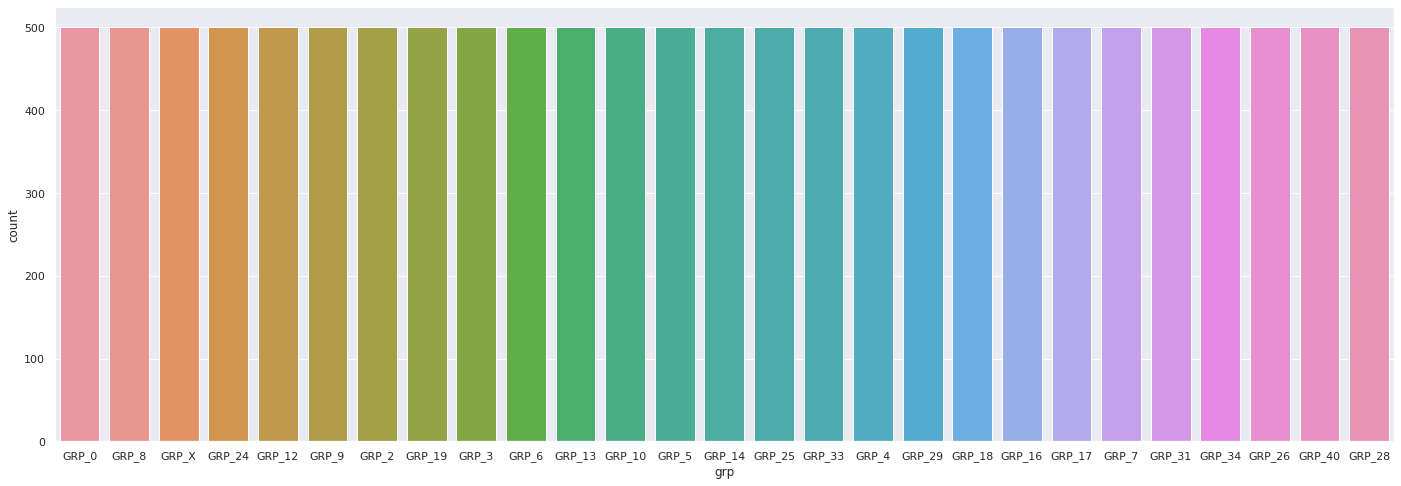

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(24, 8)})
sns.countplot(x="grp", data=df_aug )

From the above graph we can see that now we have 500 samples each after Data Augmentation

In [ ]:
df_aug.to_excel('/content/drive/MyDrive/CAPSTONE_AIML/Models/combined/AugmentedData_1.xlsx')

In [ ]:
train_set.to_excel('/content/drive/MyDrive/CAPSTONE_AIML/Models/combined/train_set.xlsx')

In [ ]:
test.to_excel('/content/drive/MyDrive/CAPSTONE_AIML/Models/combined/test.xlsx')

**Neural Network with Glove Embedding Model**

We are going to use the Augmented data for training our model. We will download and make use of Glove embeddings for better accuracy

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

from keras import layers
from keras.models import Sequential
from keras.layers import Activation, Dense, Embedding
from keras import optimizers
from keras.layers import Flatten
from keras.layers import BatchNormalization, Dropout


In [ ]:
df_aug2 = pd.read_excel ('/content/drive/MyDrive/CAPSTONE_AIML/Models/combined/AugmentedData_1.xlsx')

# Test set dont change
test = pd.read_excel ('/content/drive/MyDrive/CAPSTONE_AIML/Models/combined/test.xlsx')

# df_aug2 = pd.read_excel ('/content/drive/My Drive/DataSets/Capstone/AugmentedData_2_500.xlsx')
# test = pd.read_excel ('/content/drive/My Drive/DataSets/Capstone/test_orig_temp2.xlsx')


In [ ]:
df_aug2.head(2)

Unnamed: 0    grp                                           aug_data
0           0  GRP_0  resolve confirm company need help user login c...
1           1  GRP_0                          p printer print unable tc

Tokenize the x_train and x_test data

In [ ]:
n_most_common_words = 8000
max_len = 130

X_data = df_aug2.aug_data.astype(str)


tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_data.values)

sequences = tokenizer.texts_to_sequences(X_data.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train = pad_sequences(sequences, maxlen=max_len)
y_train = pd.get_dummies(df_aug2['grp']).values

Found 19668 unique tokens.


In [ ]:
X_test1 = test.aug_data.astype(str)

sequences1 = tokenizer.texts_to_sequences(X_test1.values)
# word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_test = pad_sequences(sequences1, maxlen=max_len)

y_test = pd.get_dummies(test['grp']).values

print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

# ((11856, 130), (11856, 27), (2964, 130), (2964, 27))
# Old data for ref

Found 19668 unique tokens.
((13500, 300), (13500, 27), (1676, 300), (1676, 27))


Download 300-d Glove embeddings

In [ ]:
# df_aug1 = pd.read_excel ('/content/drive/My Drive/DataSets/Capstone/df_aug1.xlsx')
vocab_size = len(word_index) + 1
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
# embedding_dim = 50
embedding_dim = 300
embedding_matrix = create_embedding_matrix( '/content/drive/My Drive/CAPSTONE_AIML/Models/combined/glove.6B.300d.txt', tokenizer.word_index, embedding_dim)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))

Define the model with Glove embedding and make it trainable. After the Dense layer add bachnormalization and dropout to reduce overfitting. Final layer will be Dense layer with softmax activation.
We will be using Adam optimizer and categorical crossentropy loss function as thye are appropriate in this case.

After defining the model compile and fit the model

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_len, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(layers.Dense(27, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train,
                    epochs=35,
                    verbose=1,
                    validation_split=0.1,
                    batch_size = 64)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 300)          5900700   
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              308224    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                27675     
Total params: 6,240,695
Trainable params: 6,238,647
Non-trainable params: 2,048
__________________________________________

Our model has been trained, use the test set to calculate the final accuracy

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.8441
Testing Accuracy:  0.6062


The accuracy looks good compared to previous models, considering that we have removed the bias, Also this looks to be a good improvement considering the imbalanced dataset, mislabeling etc.

We will plot confusion matrix, Roc Auc curve to better understand the performance of our model


**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  # print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  # plt.figure(figsize=(15, 8))
  plt.rcParams['figure.figsize'] = [25, 15]

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

testY_m = y_test.argmax(axis=1)

Confusion matrix, without normalization


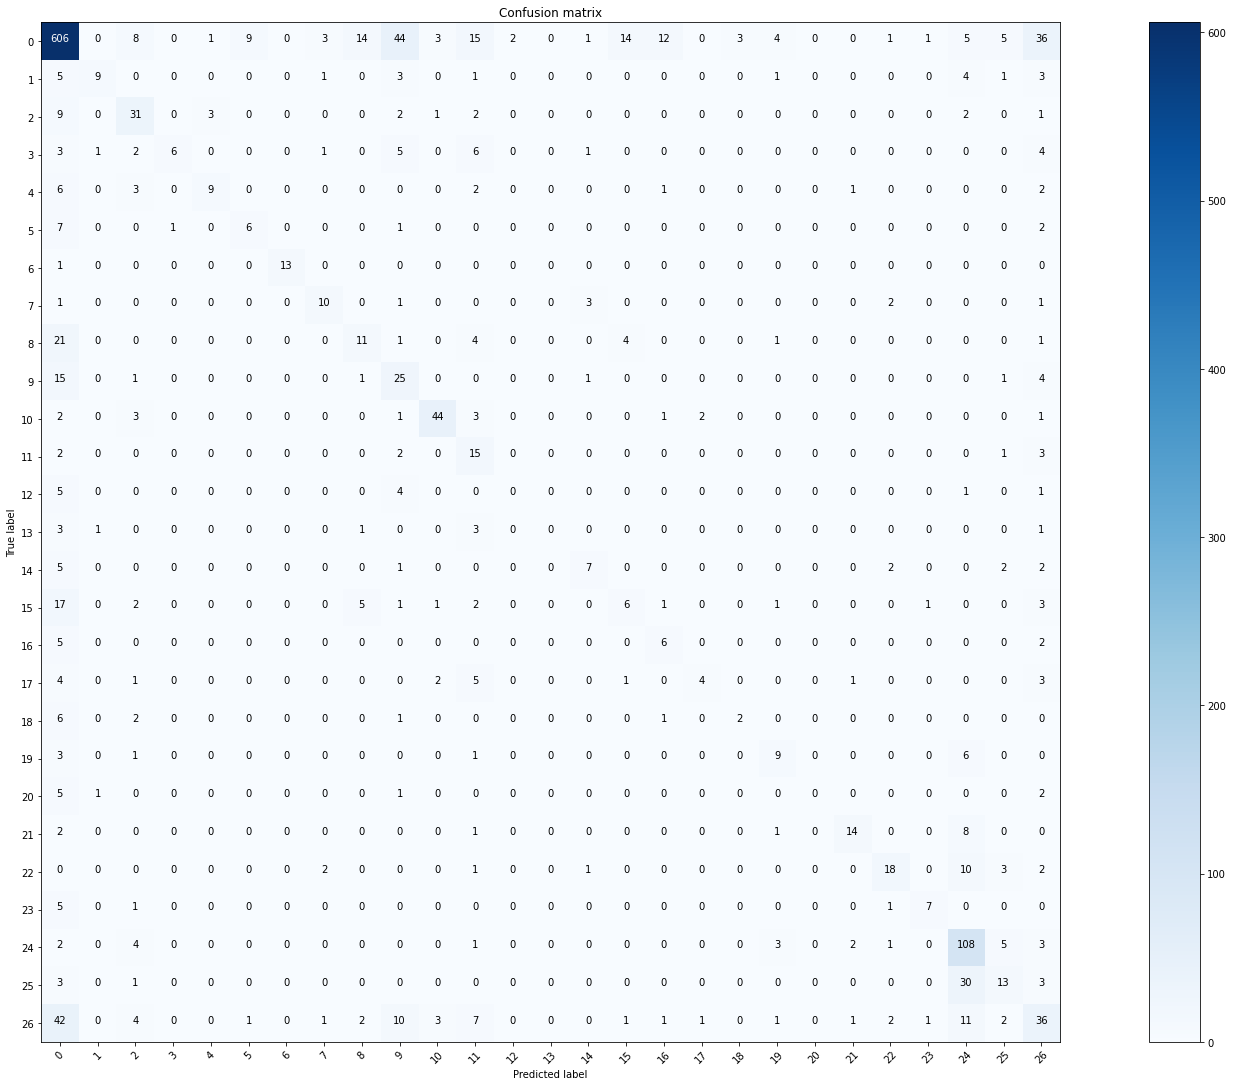

In [ ]:
cm = confusion_matrix(testY_m, testPred)
plot_confusion_matrix(cm, list(range(27)))

In [ ]:
encoder = LabelEncoder()

test_tags1 = test['grp']
encoder.fit(test_tags1)
# y_train1 = encoder.transform(train_tags1)

y_test1 = encoder.transform(test_tags1)

############  Model Used:  Neural Networks  ####################
Accuracy :  60.56085918854416
Recall: 0.61
Precision: 0.61
F1 Score: 0.61
Report :                precision    recall  f1-score   support

           0       0.77      0.77      0.77       787
           1       0.75      0.32      0.45        28
           2       0.48      0.61      0.54        51
           3       0.86      0.21      0.33        29
           4       0.69      0.38      0.49        24
           5       0.38      0.35      0.36        17
           6       1.00      0.93      0.96        14
           7       0.56      0.56      0.56        18
           8       0.32      0.26      0.29        43
           9       0.24      0.52      0.33        48
          10       0.81      0.77      0.79        57
          11       0.22      0.65      0.33        23
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         9
          14       0.50      0.37      0

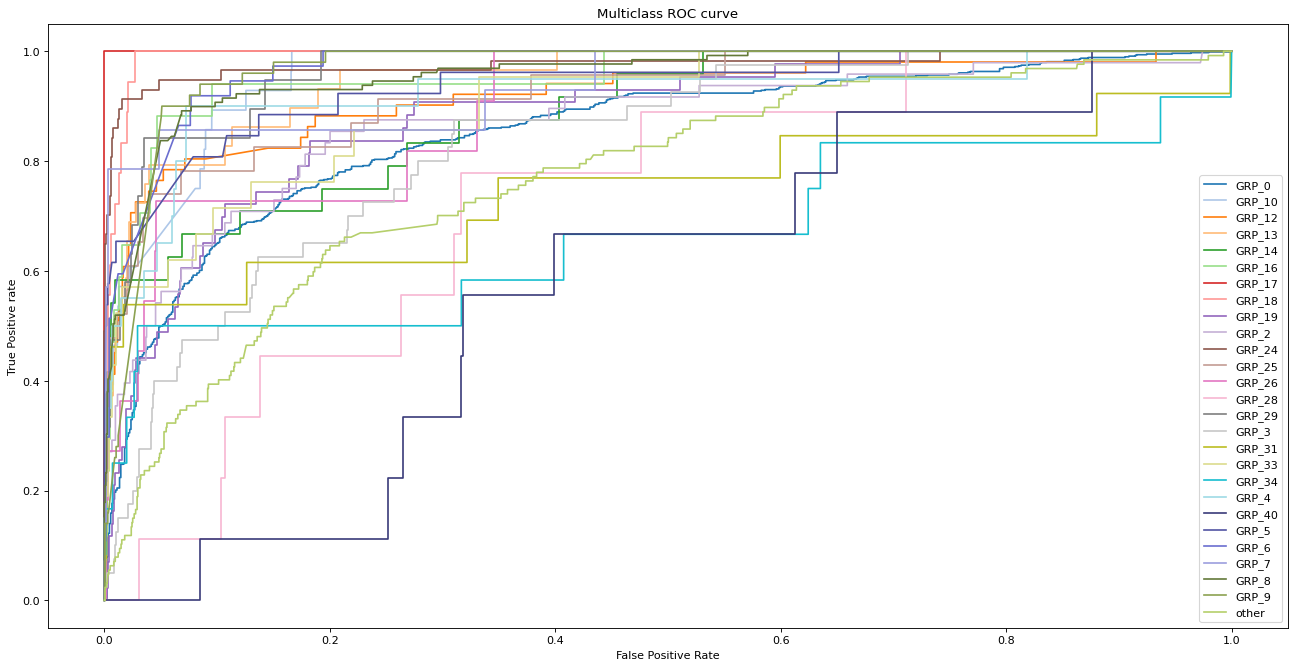

In [ ]:
model_name = 'Neural Networks'
pred_result = model.predict_classes(X_test)
pred_prob = model.predict_proba(X_test)

cal_accuracy (model_name,y_test1, pred_result)
multi_class_ROC_AUC(model_name, y_test1, pred_prob,colors)

Now that we have a trained model, we can use it to build an UI app that can reand and classsify tickets

**UI App with GRADIO**

**Load the saved models**

We will provide capability to predict to with 2 models

**Model 1:** This is our final model . It has been trained on Augmented data and uses Glove embeddings.

**Model 2:** This is a regular Neural network trained on the original data compressed into 27 classes. This model will have higher bias towards majority classes like GRP_0 and GRP_8, our model 1 should alleviate some of these issues.


In [ ]:
model_glove = load_model('/content/drive/My Drive/DataSets/Capstone/NN_Glove_2.h5')
model_NN    = load_model('/content/drive/My Drive/DataSets/Capstone/NN_Original40.h5')


Import Train data to Tokenize the input sequence as the model is trained on the Train set, the test set should get tokenized on the Train set too

In [ ]:
df_aug2 = pd.read_excel ('/content/drive/My Drive/DataSets/Capstone/AugmentedData_2_500.xlsx')
dfr_40 = pd.read_excel ('/content/drive/My Drive/DataSets/Capstone/dfr_40.xlsx')

**Functions for Gradio**

Wrap all the funcitonalities required for the model inside callable functions

In [ ]:
# Initializations

classes_dict = []
train_tags1 = df_aug2['grp']
encoder = LabelEncoder()
encoder.fit(train_tags1)
y_train = encoder.transform(train_tags1)
classes_dict = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

In [ ]:
nltk.download('stopwords')
stop = set(stopwords.words('english')) 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#function for lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [ ]:
def prepreocess (text_ip):
  temp =[]
  sentence = text_ip.lower() #converting to lowercase character
  #sentence = sentence.str.replace('\d+', '')
  cleanr = re.compile('<.*?>')
  sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
  sentence = re.sub(r'\S+@\S+', 'emailid', sentence) #substituting eamil ids with 'emailid'
  sentence = re.sub(r'\'', '', sentence, re.I|re.A)
  sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A) #Removing numbers
  #print ("Sentence1.5 = ",sentence)
  sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence) #Removing special characters
  #print ("Sentence2 = ",sentence)
  #sentence = sentence.lower()
  sentence = re.sub(r'com ', ' ', sentence, re.I|re.A) #removing com (which is a frequent word)
  sentence = re.sub(r'hello ', ' ', sentence, re.I|re.A)#removing hello (which is a frequent word)
  l_sentence = lemmatize_sentence(sentence)
  # l_sentence = re.sub(r'receive ', ' ', l_sentence, re.I|re.A)#removing receive (which is a frequent word)
  # print(sentence)
  l_sentence = re.sub(r'emailid ', ' ', l_sentence, re.I|re.A)##removing emailid (which is a frequent word)
  l_sentence = re.sub(r'emailid', ' ', l_sentence, re.I|re.A)##removing emailid (which is a frequent word)
  print("sentence = " + sentence)
  words = [word for word in l_sentence.split() if word not in stopwords.words('english')] #Remove stopwords
  words = list(set(words)) #Taking only unique words
  temp.append(words)
  print ("temp : " + str(temp))
  cleaned_sent = " ".join(words) #Joining the words to form a sentence
  print ("cleaned_sent :"+cleaned_sent)
  return cleaned_sent

In [ ]:
def tokenize_input_forGlove(test_df):
  n_most_common_words = 8000
  max_len = 130

  X_data = df_aug2.aug_data.astype(str)


  tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(X_data.values)

  sequences = tokenizer.texts_to_sequences(X_data.values)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  # X_test1 = test_df.input_data.astype(str)
  X_test1 = test_df.input_data

  sequences1 = tokenizer.texts_to_sequences(X_test1.values)
  # word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  X_test = pad_sequences(sequences1, maxlen=max_len)
  print (X_test.shape)
  return X_test

In [ ]:
def tokenize_input_forKeras(test_df):
  train_posts1 = dfr_40['Cleaned_sent'].astype(str)
  max_words = 1000
  tokenize = text.Tokenizer(num_words=max_words, char_level=False)
  tokenize.fit_on_texts(train_posts1) # only fit on train

  # X_test1 = test_df.input_data.astype(str)
  X_test1 = test_df.input_data
  X_test = tokenize.texts_to_matrix(X_test1)
  return X_test

In [ ]:
def prepare_input_forGlove(text_ip):
  # text_ip = preprocess_input(text_ip)
  test_list = []
  test_list.append(text_ip)
  print(test_list)
  test_df = pd.DataFrame(test_list, columns=['input_data'])
  X_test = tokenize_input_forGlove(test_df)
  return X_test

In [ ]:
def prepare_input_forKeras(text_ip):
  # text_ip = preprocess_input(text_ip)
  test_list = []
  test_list.append(text_ip)
  print(" in prepare input for keras :")
  print(test_list)
  test_df = pd.DataFrame(test_list, columns=['input_data'])
  X_test = tokenize_input_forKeras(test_df)
  return X_test

In [ ]:
def pred_model_glove(text_ip):
  X_test = prepare_input_forGlove(text_ip)
  prepare_labels()
  # import model and train dataset
  y_pred = model_glove.predict(X_test).argmax(axis=1)
  print ("in pred : " )
  print (y_pred)
  return y_pred

In [ ]:
def pred_model_NN(text_ip):
  X_test = prepare_input_forKeras(text_ip)
  prepare_labels()
  # import model and train dataset
  print(" in pred for keras :")
  print(X_test.shape)
  y_pred = model_NN.predict(X_test).argmax(axis=1)
  print ("in pred : " )
  print (y_pred)
  return y_pred

In [ ]:
def getLabelFromPrediction (y_pred) :
  ticket_group = list(classes_dict.keys())[list(classes_dict.values()).index(y_pred)]
  return ticket_group

In [ ]:
def ticket_assign_glove (text_ip):
  print ("input = :" + str(text_ip))
  input_text = text_ip
  text_preprocessed = prepreocess (text_ip)
  print("len")
  print (len(text_preprocessed))
  if(len(text_preprocessed) == 0):
    output_text = "Invalid input"
  else:      
    y_pred = pred_model_glove(text_preprocessed)
    ticket_group = getLabelFromPrediction (y_pred)
    output_text = "Your ticket has been registered with us and it has been assigned to group : " + str(ticket_group)
  # print (output_text)
  return output_text

In [ ]:
def ticket_assign_NN (text_ip):
  print ("input = :" + str(text_ip))
  input_text = text_ip
  text_preprocessed = prepreocess (text_ip)
  print("len")
  print (len(text_preprocessed))
  if(len(text_preprocessed) == 0):
    output_text = "Invalid input"
  else:      
    y_pred = pred_model_NN(text_preprocessed)
    ticket_group = getLabelFromPrediction (y_pred)
    output_text = "Your ticket has been registered with us and it has been assigned to group : " + str(ticket_group)
  # print (output_text)
  return output_text

**Gradio**

Gradio needs to have a main function which can be called on Submit and it should return an output that can be displayed.

In our case we have defined a function 'ticket_assign' that takes the entered input text, and pre-process it. If the text has invalid characters then we inform the user to re-enter the text.
If the text is valid then based on the model selected by the user the appropriate model is used for prediction and the result is displayed to the user.

In [ ]:
pip install gradio

In [ ]:
import gradio as gr
import random

def ticket_assingn(Issue_Description, model_name):
    print(Issue_Description, model_name)
    if model_name == "Model 1 : Neural Network with Glove Embedding Trained on Augmented data":      
      output = ticket_assign_glove(Issue_Description)
      print(output)
    else:
      output = ticket_assign_NN(Issue_Description)
      print(output)      
    return output

iface = gr.Interface(ticket_assingn, 
    ["text", gr.inputs.Radio(["Model 1 : Neural Network with Glove Embedding Trained on Augmented data", "Model 2 : Neural Network Trained on Original Data" ])],
    "text",
    title="Ticket Help Desk",
    description="Welcome! Please enter your issue",
    allow_flagging=False,    
)

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://44163.gradio.app
Interface loading below...


job failed Model 1 : Neural Network with Glove Embedding Trained on Augmented data
input = :job failed
sentence = job failed
temp : [['fail', 'job']]
cleaned_sent :fail job
len
8
['fail job']
Found 19668 unique tokens.
Found 19668 unique tokens.
(1, 130)
in pred : 
[25]
Your ticket has been registered with us and it has been assigned to group : GRP_9
